<a href="https://colab.research.google.com/github/jianghao-liu/attention-conscious-report/blob/main/Exocos_attention_conscious_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## "Fronto-parietal networks shape human conscious report through attention gain and reorienting"  

Jianghao Liu, Dimitri J. Bayle, Alfredo Spagna, Jacobo D. Sitt, Alexia Bourgeois, Katia Lehongre, Sara Fernandez-Vidal, Claude Adam, Virginie Lambrecq, Vincent Navarro, Tal Seidel Malkinson, Paolo Bartolomeo  

https://www.biorxiv.org/content/10.1101/2022.04.10.487690v4



## Using RNN to simulate consciousness task

1.   Set environment
2.   Define a new task model with RNN
3.   Model training
4.   Model probing and trial sample
5.   PCA/t-SNE analysis to investigate task representation
6.   Trajectory k-mean method about temporal dynamics
7.   PCA/t-SNE analysis on cluster
8.   lesion analysis by cluster
9.   NeuroData PCA visualization

***



## 1 - Set environment

In [2]:
# THIS CELL SETS STUFF UP FOR DEMO / COLLAB. THIS CELL CAN BE IGNORED.

#-------------------------------------GET RID OF TF DEPRECATION WARNINGS---------------------------------------#
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#----------------------------------INSTALL PSYCHRNN IF IN A COLAB NOTEBOOK-------------------------------------#
# Installs the correct branch / release version based on the URL. If no branch is provided, loads from master.
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import json
    import re
    import ipykernel
    import requests
    from requests.compat import urljoin
    import os

    from notebook.notebookapp import list_running_servers
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path'].split('%2F')
                if 'blob' in relative_path:
                  blob = relative_path[relative_path.index('blob') + 1]
                  !pip install git+https://github.com/murraylab/PsychRNN@$blob
                else:
                  !pip install git+https://github.com/murraylab/PsychRNN

    if not os.path.exists("./weights"):
        os.makedirs("./weights")

  Cloning https://github.com/murraylab/PsychRNN to /tmp/pip-req-build-_xqbq7jh
  Running command git clone --filter=blob:none --quiet https://github.com/murraylab/PsychRNN /tmp/pip-req-build-_xqbq7jh
  Resolved https://github.com/murraylab/PsychRNN to commit 2f5415534de786b2901fd3b5914d94c94a0f68fa
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
!pip install psychrnn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install scipy

from psychrnn.backend.models.basic import Basic
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

import scipy.io

import numpy as np
import random

seed=2021

tf.compat.v2.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy import stats


## 2 - Define a new task model with RNN





In [ ]:
from psychrnn.tasks.task import Task
import numpy as np

class ExogenousAttention(Task):

    """Near-threshold target detection task with exogenous attention effect

    Following a fore period, the network receives a cue, followed by a fixed cue-target delay. After the delay the network receives a target stimulus.
    Since the position of cue have a impact on the perception of the subsequent target, the network have to report whether the target was present or absent after a second fixed delay.

    The network takes two noisy inputs which simulate visual stimuli coming from two sides of the field of view. (:attr:`N_in` = 2).
    Two outputs (:attr:`N_out` = 2) with a one hot encoding showing whether the target was present or absent and the side where the target was present (present is 1, absent is 0).

    The amplifying effect on stimuli by attention is modelled by multiplying input signal with an attentional gain value, at validly cued position.

    Behaviorial performance of the network is measured by the target detection accuracy.

    Args:

        attention_gain (float, optional): Coefficiant of attentional amplifying effect.
        target_indensity (float, optional): Intensity of target stimulus

        dt (float): The simulation timestep.
        tau (float): The intrinsic time constant of neural state decay.
        T (float): The trial length.
        N_batch (int): The number of trials per training update.
        onset_time (float, optional): Cue onset time in terms of trial length :data:`T`.
        stim_duration_1 (float, optional): Cue duration in terms of trial length :data:`T`.
        delay_duration_1 (float, optional): Cue-target delay (Stimulus onset asynchrony) in terms of trial length :data:`T`.
        stim_duration_2 (float, optional): Target duration in terms of trial length :data:`T`.
        delay_duration_2 (float, optional): Delay to prepare the response in terms of trial length :data:`T`.
        decision_duration (float, optional): Response duration in terms of trial length :data:`T`.
    """

    def __init__(self, dt, tau, T, N_batch, attention_gain = 1.5, target_indensity = 0.10, onset_time = None, stim_duration_1 = None, delay_duration_1 = None, stim_duration_2 = None, delay_duration_2 = None, decision_duration = None):
        super(ExogenousAttention,self).__init__(2, 2, dt, tau, T, N_batch)

        self.attention_gain = attention_gain
        self.target_indensity = target_indensity

        self.onset_time = onset_time
        self.stim_duration_1 = stim_duration_1
        self.delay_duration_1 = delay_duration_1
        self.stim_duration_2 = stim_duration_2
        self.delay_duration_2 = delay_duration_2
        self.decision_duration = decision_duration

    def generate_trial_params(self, batch, trial):
        """"Define parameters for each trial.

        Using a combination of randomness, presets, and task attributes, define the necessary trial parameters.

        Args:
            batch (int): The batch number that this trial is part of.
            trial (int): The trial number of the trial within the batch.

        Returns:
            dict: Dictionary of trial parameters.

            :Dictionary Keys:  (millisecond)
                * **stimulus_1** (*float*) -- Start time for stimulus one. :data:`onset_time`.
                * **delay1** (*float*) -- Start time for the delay. :data:`onset_time` + :data:`stimulus_duration_1`.
                * **stimulus_2** (*float*) -- Start time in for stimulus one. :data:`onset_time` + :data:`stimulus_duration_1` + :data:`delay_duration_1`.
                * **delay2** (*float*) -- Start time for the delay. :data:`onset_time` + :data:`stimulus_duration_1` + :data:`delay_duration_1` + :data:`stimulus_duration_2`.
                * **decision** (*float*) -- Start time in for decision period. :data:`onset_time` + :data:`stimulus_duration_1` + :data:`delay_duration_1` + :data:`stimulus_duration_2`+ delay_duration_2.
                * **end** (*float*) -- End of decision period. :data:`onset_time` + :data:`stimulus_duration_1` + :data:`delay_duration` + :data:`stimulus_duration_2` + :data:`decision_duration`.
                * **stim_noise** (*float*) -- Scales the stimlus noise. following Gaussian N(0,0.05) for visual processing noise

                * **cue_position** (*float*) -- Indicates whether the cue is present in left '0' or right side '1'.
                * **target_position** (*float*) -- Indicates whether the target is present in left '0' or right side '1'.
                * **detection** (*float*) -- Indicates whether the target is present in this trial : '0' absent or '1' present.
        """

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()


        if self.onset_time is None:
            onset_time = 200
        else:
            onset_time = self.onset_time

        if self.stim_duration_1 is None:
            stim_duration_1 = 160
        else:
            stim_duration_1 = self.stim_duration_1

        if self.delay_duration_1 is None:
            delay_duration_1 = 200
        else:
            delay_duration_1 = self.delay_duration_1

        if self.stim_duration_2 is None:
            stim_duration_2 = 160
        else:
            stim_duration_2 = self.stim_duration_2

        if self.delay_duration_2 is None:
            delay_duration_2 = 200
        else:
            delay_duration_2 = self.delay_duration_2

        if self.decision_duration is None:
            decision_duration = 100
        else:
            decision_duration = self.decision_duration


        params['stimulus_1'] = onset_time
        params['delay_1'] = onset_time + stim_duration_1
        params['stimulus_2'] = onset_time + stim_duration_1 + delay_duration_1
        params['delay_2'] = onset_time + stim_duration_1 + delay_duration_1 + stim_duration_2
        params['decision'] = onset_time + stim_duration_1 + delay_duration_1 + stim_duration_2 + delay_duration_2
        params['end'] = onset_time + stim_duration_1 + delay_duration_1 + stim_duration_2 + delay_duration_2 + decision_duration

        params['cue_position'] =  np.random.choice([0, 1])
        params['target_position'] =  np.random.choice([0, 1])

        params['detection'] = np.random.choice([0,1], p = [0.33,0.67])

        params['stim_noise'] = 0.1

        params['attention_gain'] = self.attention_gain
        params['target_indensity'] = self.target_indensity

        return params

    def trial_function(self, time, params):
        """ Compute the trial properties at the given time.

        Based on the params compute the trial stimulus (x_t), correct output (y_t), and mask (mask_t) at the given time.

        Args:
            time (int): The time within the trial (0 <= time < T).
            params (dict): The trial params produced generate_trial_params()

        Returns:
            tuple:

            x_t (ndarray(dtype=float, shape=(N_in,))): Trial input at time given params.
            y_t (ndarray(dtype=float, shape=(N_out,))): Correct trial output at time given params.
            mask_t (ndarray(dtype=bool, shape=(N_out,))): True if the network should train to match the y_t, False if the network should ignore y_t when training.

        """

        # ----------------------------------
        # Initialize with noise
        # ----------------------------------

        x_t = np.sqrt(2*.01*np.sqrt(10)*np.sqrt(self.dt)*params['stim_noise']*params['stim_noise'])*np.random.randn(self.N_in)
        y_t = np.zeros(self.N_out)
        mask_t = np.zeros(self.N_out)

        # ----------------------------------
        # Retrieve parameters
        # ----------------------------------

        # --- timeline params
        stimulus_1 = params['stimulus_1']
        delay_1 = params['delay_1']
        stimulus_2 = params['stimulus_2']
        delay_2 = params['delay_2']
        decision = params['decision']
        end = params['end']

        #--- task params
        cue_position = params['cue_position']
        target_position = params['target_position']

        detection = params['detection']

        gain = params['attention_gain']
        target_indensity = params['target_indensity']

        cue_indensity = 0.3


        # ----------------------------------
        # Compute values
        # ----------------------------------
        if stimulus_1 <= time < delay_1:
            x_t[cue_position] += cue_indensity + np.random.normal(0, 0.05)
            x_t[1-cue_position] += np.random.normal(0, 0.05)

        if stimulus_2 <= time < delay_2:
            if target_position == cue_position:
                x_t[target_position] += target_indensity * detection * gain + np.random.normal(0, 0.05)
                x_t[1-target_position] += np.random.normal(0, 0.05)
            else:
                x_t[target_position] += target_indensity * detection + np.random.normal(0, 0.05)
                x_t[1-target_position] += np.random.normal(0, 0.05) * gain

        if decision + 20 < time < end:
            y_t[0] = (1-target_position) * detection
            y_t[1] = target_position * detection
            mask_t = np.ones(self.N_out)

        return x_t, y_t, mask_t


    # this function doesn't used by training loss
    def accuracy_function(self, correct_output, test_output, output_mask):
        """Calculates the accuracy of :data:`test_output`.

        Implements :func:`~psychrnn.tasks.task.Task.accuracy_function`.

        Takes the channel-wise mean of the masked output for each trial. Whichever channel has a greater mean is considered to be the network's "choice".

        Returns:
            float: 0 <= accuracy <= 1. Accuracy is equal to the ratio of trials in which the network made the correct choice as defined above.

        """
        m_start = np.nonzero(output_mask[0]==1)[0][0]    # find the start of mask
        m_end = np.nonzero(output_mask[0]==1)[0][-1]     # find the end of mask
        output_raw = np.mean(test_output[:,m_start:m_end,:], axis=1)
        output_raw[output_raw >= 0.5] = 1                # transfer output to binary value
        output_raw[output_raw < 0.5] = 0
        correct_y = np.mean(correct_output[:,m_start:m_end,:], axis=1)

        return np.mean([(output_raw[idx] == correct_y[idx]).all() for idx in range(np.shape(output_raw)[0])])


    # this function doesn't used by training loss
    def accuracy_function_seen(self, correct_output, test_output, output_mask):
        """Calculates the accuracy of :data:`test_output`.
        Discrimination task for the

        Implements :func:`~psychrnn.tasks.task.Task.accuracy_function`.

        Takes the channel-wise mean of the masked output for each trial. Whichever channel has a greater mean is considered to be the network's "choice".

        Returns:
            float: 0 <= accuracy <= 1. Accuracy is equal to the ratio of trials in which the network made the correct choice as defined above.

        """
        chosen = np.argmax(np.mean(test_output*output_mask, axis=1), axis = 1)
        truth = np.argmax(np.mean(correct_output*output_mask, axis = 1), axis = 1)
        return np.mean(np.equal(truth, chosen))


### Some utils functions
def lesion_units(weights, units):
        """
            Lesion units: reset input, output weights and recurrent weights with other units to zero.
            units : can be None, an integer index, or a list of integer indices
        """

        if units is None:
            return weights
        else:
            units = np.array(units)

            # Input weights
            weights['W_in'][units,:] = 0
            # output weights
            for i in range(np.shape(weights['W_out'])[0]):
              weights['W_out'][i][units] = 0
            # recurrent weights
              weights['W_rec'][units, :] = 0

            return weights

def test_model_acc(ExocosModel, basicModel):
  """
  calculate accuracy of model

  """
  V_acc = []
  Inv_acc = []
  Absence_acc = []
  All_acc = []

  for i_batch in range(50):
      x,y,m, trial_params = ExocosModel.get_trial_batch()
      output, state_var = basicModel.test(x)

      Absence_idx = [];
      V_idx = [];
      Inv_idx = [];

      for i in range(50):
        if trial_params[i]['detection'] == 0:
          Absence_idx.append(i)
        elif trial_params[i]['cue_position'] == trial_params[i]['target_position']:
          V_idx.append(i)
        else:
          Inv_idx.append(i)

      V_acc.append(ExocosModel.accuracy_function(y[V_idx,:,:],output[V_idx,:,:],m[V_idx,:,:]))
      Inv_acc.append(ExocosModel.accuracy_function(y[Inv_idx,:,:],output[Inv_idx,:,:],m[Inv_idx,:,:]))
      Absence_acc.append(ExocosModel.accuracy_function(y[Absence_idx,:,:],output[Absence_idx,:,:],m[Absence_idx,:,:]))
      All_acc.append(ExocosModel.accuracy_function(y,output,m))

  return V_acc, Inv_acc,Absence_acc,All_acc

def test_model_acc_seen(ExocosModel, basicModel):
  """
  calculate accuracy of model for perceiving validly and invalidly cued target

  """
  V_acc = []
  Inv_acc = []

  for i_batch in range(50):
      x,y,m, trial_params = ExocosModel.get_trial_batch()
      output, state_var = basicModel.test(x)
      V_idx = [];
      Inv_idx = [];

      for i in range(50):
        if trial_params[i]['detection'] == 0:
          pass
        elif trial_params[i]['cue_position'] == trial_params[i]['target_position']:
          V_idx.append(i)
        else:
          Inv_idx.append(i)

      V_acc.append(ExocosModel.accuracy_function_seen(y[V_idx,:,:],output[V_idx,:,:],m[V_idx,:,:]))
      Inv_acc.append(ExocosModel.accuracy_function_seen(y[Inv_idx,:,:],output[Inv_idx,:,:],m[Inv_idx,:,:]))

  return [V_acc, Inv_acc]


def plot_sample(trlnum,x,y,m, trial_params,output,state_var):
  """
  plot trial sample to check the state variables

  """
  trl = trlnum # plot trial num

  print("cue_position :", trial_params[trl]['cue_position'])
  print("target_position : ", trial_params[trl]['target_position'])
  print("detection : ", trial_params[trl]['detection'])

  fig = plt.gcf()
  fig.set_size_inches(6, 4)

  ax1 = plt.subplot(311)
  plt.plot(range(0, len(x[0,:,:])*dt,dt), x[trl,:,:])
  plt.ylabel("Stim intensity")
  plt.legend(["Input 1", "Input 2"])
  plt.ylim(-0.2, 0.6)
  plt.setp(ax1.get_xticklabels(), visible=False)

  # share x only
  ax2 = plt.subplot(312, sharex=ax1)
  plt.plot(range(0, len(x[0,:,:])*dt,dt), y[trl,:,:])
  plt.ylabel("Target presence")
  plt.legend(["y1","y2"])
  # make these tick labels invisible
  plt.setp(ax2.get_xticklabels(), visible=False)
  plt.ylim(-0.2, 1.5)

  # share x and y
  ax3 = plt.subplot(313, sharex=ax1)
  plt.plot(range(0, len(x[0,:,:])*dt,dt), m[trl,:,:])
  plt.ylabel("Decision mask")
  plt.xlabel("Time (ms)")
  plt.legend(["Mask1", "Mask2"])
  plt.ylim(-0.2, 1.5)
  plt.show()

  fig = plt.gcf()
  fig.set_size_inches(6, 4)

  ax1 = plt.subplot(211)
  plt.plot(range(0, len(output[0,:,:])*dt,dt),output[trl,:,:])
  plt.ylabel("Activity of Output Unit")
  plt.title("Target detection strength")
  plt.legend(["Output 1", "Output 2"])
  plt.setp(ax1.get_xticklabels(), visible=False)

  ax2 = plt.subplot(212)
  plt.plot(range(0, len(state_var[0,:,:])*dt,dt),state_var[trl,:,:])
  plt.ylabel("State Variable Value")
  plt.xlabel("Time (ms)")
  plt.title("Evolution of State Variables over Time")
  plt.show()

## 3 - Model training

### model parameters

In [ ]:
dt = 10 # The simulation timestep.
tau = 100 # The intrinsic time constant of neural state decay.
T = 1600 # The trial length.
N_batch = 50 # The number of trials per training update.
N_rec = 50 # The number of recurrent units in the network.
name = 'ExocosModel' #  Unique name used to determine variable scope for internal use.

ExocosModel = ExogenousAttention(target_indensity = 0.10, dt = dt, tau = tau, T = T, N_batch = N_batch, attention_gain = 1.5)

## Initialize Model
network_params = ExocosModel.get_task_params()

##----------
# Network params
##----------

network_params['dale_ratio'] = 0.8
network_params['name'] = name # Unique name used to determine variable scope.
network_params['N_rec'] = N_rec # The number of recurrent units in the network.
network_params['rec_noise'] = 0.05 # Noise into each recurrent unit. Default: 0.0
network_params['W_in_train'] = True # Indicates whether W_in is trainable. Default: True
network_params['W_rec_train'] = True # Indicates whether W_rec is trainable. Default: True
network_params['W_out_train'] = True # Indicates whether W_out is trainable. Default: True
network_params['b_rec_train'] = True # Indicates whether b_rec is trainable. Default: True
network_params['b_out_train'] = True # Indicates whether b_out is trainable. Default: True
network_params['init_state_train'] = True # Indicates whether init_state is trainable. Default: True
network_params['transfer_function'] = tf.nn.relu # Transfer function to use for the network. Default: tf.nn.relu.
network_params['loss_function'] = "mean_squared_error"# String indicating what loss function to use. If not `mean_squared_error` or `binary_cross_entropy`, params["loss_function"] defines the custom loss function. Default: "mean_squared_error".
network_params['load_weights_path'] = None # When given a path, loads weights from file in that path. Default: None
# network_params['initializer'] = # Initializer to use for the network. Default: WeightInitializer (network_params) if network_params includes W_rec or load_weights_path as a key, GaussianSpectralRadius (network_params) otherwise.
network_params['which_rand_init'] = 'glorot_gauss' # Which random initialization to use for W_in and W_out. Will also be used for W_rec if which_rand_W_rec_init is not passed in. Options: 'const_unif', 'const_gauss', 'glorot_unif', 'glorot_gauss'. Default: 'glorot_gauss'.
network_params['which_rand_W_rec_init'] = network_params['which_rand_init'] # 'Which random initialization to use for W_rec. Options: 'const_unif', 'const_gauss', 'glorot_unif', 'glorot_gauss'. Default: which_rand_init.
network_params['init_minval'] = -.1 # Used by const_unif_init() as minval if 'const_unif' is passed in for which_rand_init or which_rand_W_rec_init. Default: -.1.
network_params['init_maxval'] = .1 # Used by const_unif_init() as maxval if 'const_unif' is passed in for which_rand_init or which_rand_W_rec_init. Default: .1.

####-----------------------
# Regularization Parameters
### -----------------------

network_params['L1_in'] = 0 # Parameter for weighting the L1 input weights regularization. Default: 0.
network_params['L1_rec'] = 0 # Parameter for weighting the L1 recurrent weights regularization. Default: 0.
network_params['L1_out'] = 0 # Parameter for weighting the L1 output weights regularization. Default: 0.
network_params['L2_in'] = 0 # Parameter for weighting the L2 input weights regularization. Default: 0.
network_params['L2_rec'] = 0 # Parameter for weighting the L2 recurrent weights regularization. Default: 0.
network_params['L2_out'] = 0 # Parameter for weighting the L2 output weights regularization. Default: 0.
network_params['L2_firing_rate'] = 0 # Parameter for weighting the L2 regularization of the relu thresholded states. Default: 0.
network_params['custom_regularization'] = None # Custom regularization function. Default: None.


### Option: Training parameters (to re-train the model)

In [ ]:
## define a model instance and initialization
basicModel = Basic(network_params)

# Set the training parameters for our model.
train_params = {}
train_params['save_weights_path'] =  None # Where to save the model after training. Default: None
train_params['training_iters'] = 150000 # number of iterations to train for Default: 50000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['optimizer'] = tf.compat.v1.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True
train_params['fixed_weights'] = None # Dictionary of weights to fix (not allow to train). Default: None

## Example usage of the optional performance_cutoff and performance_measure parameters is available in Curriculum Learning tutorial.
train_params['performance_cutoff'] = None # If performance_measure is not None, training stops as soon as performance_measure surpases the performance_cutoff. Default: None.
train_params['performance_measure'] = None # Function to calculate the performance of the network using custom criteria. Default: None.]

In [ ]:
## model training
losses, initialTime, trainTime = basicModel.train(ExocosModel, train_params)

Iter 500, Minibatch Loss= 0.009556
Iter 1000, Minibatch Loss= 0.010561
Iter 1500, Minibatch Loss= 0.007969
Iter 2000, Minibatch Loss= 0.007795
Iter 2500, Minibatch Loss= 0.007670
Iter 3000, Minibatch Loss= 0.008001
Iter 3500, Minibatch Loss= 0.007219
Iter 4000, Minibatch Loss= 0.007615
Iter 4500, Minibatch Loss= 0.008412
Iter 5000, Minibatch Loss= 0.006988
Iter 5500, Minibatch Loss= 0.008131
Iter 6000, Minibatch Loss= 0.007905
Iter 6500, Minibatch Loss= 0.007864
Iter 7000, Minibatch Loss= 0.008555
Iter 7500, Minibatch Loss= 0.007950
Iter 8000, Minibatch Loss= 0.006087
Iter 8500, Minibatch Loss= 0.007226
Iter 9000, Minibatch Loss= 0.006998
Iter 9500, Minibatch Loss= 0.007836
Iter 10000, Minibatch Loss= 0.006587
Iter 10500, Minibatch Loss= 0.007777
Iter 11000, Minibatch Loss= 0.006197
Iter 11500, Minibatch Loss= 0.008586
Iter 12000, Minibatch Loss= 0.008067
Iter 12500, Minibatch Loss= 0.008125
Iter 13000, Minibatch Loss= 0.008468
Iter 13500, Minibatch Loss= 0.007691
Iter 14000, Minibatch

Text(0.5, 1.0, 'Loss During Training')

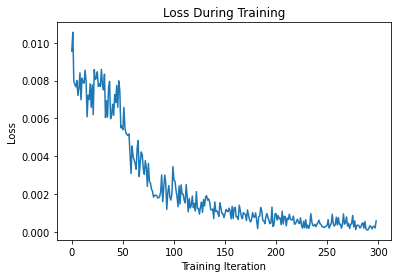

In [ ]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

In [ ]:
basicModel.save("./drive/MyDrive/Colab Notebooks/TrainedModelStates/ExocosTrainedModels__I150000_Target0p10_Gain1p5_summary")

### Option: Load trained model

In [ ]:
## load trained model to reproduce the figures
load_network_params = network_params.copy()
load_network_params['load_weights_path'] = './drive/MyDrive/Colab Notebooks/TrainedModelStates/ExocosTrainedModels__I150000_' + 'Target0p10_Gain1p5_summary' + '.npz'

basicModel = Basic(load_network_params)

## 4 - Model probing and trial sample

### target intensity

In [ ]:
V_param = [];
Inv_param = [];
Absence_param = [];
All_param = [];

prob_intensity = np.arange(0.00,0.13,0.01)

for this_intensity in prob_intensity:

  ExocosModel = ExogenousAttention(dt = dt, tau = tau, T = T, N_batch = N_batch, target_indensity = this_intensity) # Initialize the task object

  V_acc, Inv_acc,Absence_acc,All_acc = test_model_acc(ExocosModel,basicModel)

  print("Computing : " + "{:.2f}".format(this_intensity))
  V_param.append(V_acc)
  Inv_param.append(Inv_acc)
  Absence_param.append(Absence_acc)
  All_param.append(All_acc)


Computing : 0.00
Computing : 0.01
Computing : 0.02
Computing : 0.03
Computing : 0.04
Computing : 0.05
Computing : 0.06
Computing : 0.07
Computing : 0.08
Computing : 0.09
Computing : 0.10
Computing : 0.11
Computing : 0.12


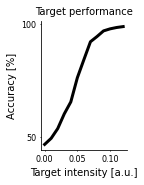

In [ ]:
target_indensities = prob_intensity

fig = plt.figure(figsize=(2, 3))
ax = fig.add_axes([0.3,0.2, 0.6, 0.6])

ax.plot(target_indensities,np.mean(All_param,axis=1) * 100, linewidth= 3, color = 'black')

text_font = 10

plt.xlabel('Target intensity [a.u.]', fontsize=text_font)
plt.ylabel('Accuracy [%]', fontsize=text_font)
plt.title('Target performance', fontsize=text_font, y=1)
plt.locator_params(axis='y', nbins=2)
ax.tick_params(axis='both', which='major', labelsize=8, length=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plt.savefig('./drive/MyDrive/Colab Notebooks/figure/Performance_turning_target0p10.png',dpi = 300)


### Trials sample and units state variables

In [ ]:
this_target = 0.10
ExocosModel = ExogenousAttention(target_indensity= this_target, dt = dt, tau = tau, T = T, N_batch = N_batch, attention_gain = 1.5) # Initialize the task object
# generate testing trial batch
x,y,m, trial_params = ExocosModel.get_trial_batch()
# generate testing output from trained models
output, state_var = basicModel.test(x)

In [ ]:
trial_params

array([{'stimulus_1': 200, 'delay_1': 360, 'stimulus_2': 560, 'delay_2': 720, 'decision': 920, 'end': 1020, 'cue_position': 0, 'target_position': 1, 'detection': 1, 'stim_noise': 0.1, 'attention_gain': 1.5, 'target_indensity': 0.1},
       {'stimulus_1': 200, 'delay_1': 360, 'stimulus_2': 560, 'delay_2': 720, 'decision': 920, 'end': 1020, 'cue_position': 0, 'target_position': 1, 'detection': 1, 'stim_noise': 0.1, 'attention_gain': 1.5, 'target_indensity': 0.1},
       {'stimulus_1': 200, 'delay_1': 360, 'stimulus_2': 560, 'delay_2': 720, 'decision': 920, 'end': 1020, 'cue_position': 0, 'target_position': 1, 'detection': 1, 'stim_noise': 0.1, 'attention_gain': 1.5, 'target_indensity': 0.1},
       {'stimulus_1': 200, 'delay_1': 360, 'stimulus_2': 560, 'delay_2': 720, 'decision': 920, 'end': 1020, 'cue_position': 0, 'target_position': 0, 'detection': 1, 'stim_noise': 0.1, 'attention_gain': 1.5, 'target_indensity': 0.1},
       {'stimulus_1': 200, 'delay_1': 360, 'stimulus_2': 560, 'delay

In [ ]:
## save to Matlab format for reproductibility
output_struct = {"x":x,
                 "y":y,
                 "m":m,
                 "trial_params":trial_params,
                 "output": output,
                 "state_var":state_var
                }

scipy.io.savemat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_output_trial_examples', output_struct)

In [ ]:
# reproductibility of figure
trial_example = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_output_trial_examples')
x = trial_example['x']
state_var =  trial_example['state_var']
output = trial_example['output']

cue_position : 0
target_position :  0
detection :  0


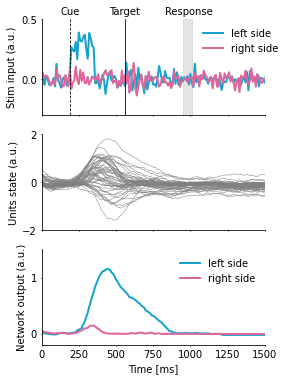

In [ ]:
from matplotlib.patches import Rectangle

trl = 49 # invalid : 1# valid : 5 # absence : 49 # plot trial num
print("cue_position :", trial_params[trl]['cue_position'])
print("target_position : ", trial_params[trl]['target_position'])
print("detection : ", trial_params[trl]['detection'])


text_font = 10
tick_font = 10

fig = plt.figure(figsize=(4, 6))
ax = fig.add_axes([0.3,0.2, 0.6, 0.8])

ax = plt.subplot(311)
plt.plot(range(0, len(x[0,:,0])*dt,dt), x[trl,:,0], linewidth=2, color=(21/255,163/255,205/255))
plt.plot(range(0, len(x[0,:,1])*dt,dt), x[trl,:,1], linewidth=2, color=(221/255,102/255,155/255))

plt.ylabel("Stim input (a.u.)", fontsize=text_font)
plt.legend(["left side", "right side"], fontsize=text_font, frameon=False, bbox_to_anchor=(0.1, 0.9, 1., .1))

ylim = (-0.3, 0.5)
plt.ylim(ylim)
plt.xlim(0, 1500)

plt.axvline(x=190, color = 'k', ls='--',linewidth=0.8)
plt.axvline(x=560, color = 'k', ls='-', linewidth=0.8)

start_mask = np.where(m[0,:,0] == 1)[0][0]
end_mask  = np.where(m[0,:,0] == 1)[0][-1]

plt.text(190, 0.52, 'Cue', ha='center', va='bottom', fontsize =10)
plt.text(560, 0.52, 'Target', ha='center', va='bottom', fontsize =10)
plt.text(start_mask*10+40, 0.52, 'Response', ha='center', va='bottom', fontsize =10)

rect = Rectangle((start_mask*10, ylim[0]), (end_mask - start_mask) *10 , ylim[1] - ylim[0] ,color='gray',alpha = 0.2 )
ax.add_patch(rect)

plt.locator_params(axis='y', nbins=2)
ax.tick_params(axis='both', which='major', labelsize=tick_font, length=1)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.setp(ax.get_xticklabels(), visible=False)

# share x - plot state variables

ax2 = plt.subplot(312, sharex=ax)
plt.plot(range(0, len(state_var[0,:,:])*dt,dt),state_var[trl,:,:],linewidth=0.5, color='gray')
plt.ylabel("Units state (a.u.)")

plt.ylim(-2,2)

plt.locator_params(axis='y', nbins=2)
ax2.tick_params(axis='both', which='major', labelsize=tick_font, length=1)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
plt.setp(ax2.get_xticklabels(), visible=False)

# share x - plot output
ax3 = plt.subplot(313, sharex=ax)
plt.plot(range(0, len(output[0,:,0])*dt,dt), output[trl,:,0], linewidth=2, color=(21/255,163/255,205/255))
plt.plot(range(0, len(output[0,:,1])*dt,dt), output[trl,:,1], linewidth=2, color=(221/255,102/255,155/255))

plt.ylabel("Network output (a.u.)")
plt.legend(["left side", "right side"], fontsize=text_font, frameon=False)
plt.ylim(-0.2,1.5)

plt.locator_params(axis='y', nbins=3)
ax3.tick_params(axis='both', which='major', labelsize=tick_font, length=1)
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_ticks_position('left')
plt.xlabel("Time [ms]")

plt.savefig('./drive/MyDrive/Colab Notebooks/figure/RNN_task_represent_absent.pdf',dpi = 300)
#plt.savefig('./drive/MyDrive/Colab Notebooks/figure/RNN_task_represent_valid.pdf',dpi = 300)
#plt.savefig('./drive/MyDrive/Colab Notebooks/figure/RNN_task_represent_invalid.pdf',dpi = 300)


## 5 - PCA/t-SNE analysis to investigate task representation

### generate new trials samples and trained output

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

targetlevel = ["low","intermediate","high"]
this_targets = [0.01, 0.20, 0.30]  # probing contrast
Label_Detection_all = []
state_var_all = []

for this_target in this_targets:

  ExocosModel = ExogenousAttention(target_indensity= this_target, dt = dt, tau = tau, T = T, N_batch = N_batch, attention_gain = 1.5)
  # create labels and trials samples
  Label_Detection = []
  Label_Interaction = []
  state_var_concate = np.zeros((0,0,0))
  target_name = ['no target', 'seen valid', 'seen inv']

  # 0 : no target
  # 1 : detected / SV
  # 2 : SIv
  for trialblock in range(20):   # 20 blocks * 50 trials = 1000 trials
    x,y,m, trial_params = ExocosModel.get_trial_batch()
    # generate testing output from trained models
    output, state_var = basicModel.test(x)

    if trialblock == 0:
      state_var_concate = state_var
    else:
      state_var_concate = np.concatenate((state_var_concate,state_var),axis=0)

    for i, this_trial in enumerate(trial_params):
      if this_trial['detection'] == 0:
        Label_Detection.append(0)
      elif this_trial['cue_position'] == this_trial['target_position']:
        Label_Detection.append(1)
      else:
        Label_Detection.append(2)

  print(np.shape(Label_Detection))
  print(np.shape(state_var_concate))

  Label_Detection_all.append(Label_Detection)
  state_var_all.append(state_var_concate)

## save to Matlab format
output_struct = {"Label_Detection_all":Label_Detection_all,
                 "state_var_all":state_var_all,
                 "experiment": "exocos_RNN",
                }

scipy.io.savemat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_output_1000trialexamples.mat', output_struct)

(1000,)
(1000, 160, 50)
(1000,)
(1000, 160, 50)
(1000,)
(1000, 160, 50)


In [ ]:
data_alloc = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_output_1000trialexamples.mat')
Label_Detection_all = data_alloc['Label_Detection_all']
state_var_all = data_alloc['state_var_all']

##### prepare data for autoencoder only

In [ ]:
## take some outputs to train Autoencoder.

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

x_all = []
y_all = []
m_all = []
trial_params_all = []

# creat model instance
ExocosModel = ExogenousAttention(target_indensity= this_target, dt = dt, tau = tau, T = T, N_batch = N_batch, attention_gain = 1.5)

for trialblock in range(20):   # 20 blocks * 50 trials = 1000 trials
  x,y,m, trial_params = ExocosModel.get_trial_batch()
  # generate testing output from trained models
  # output, state_var = basicModel.test(x)

  x_all.append(x)
  y_all.append(y)
  m_all.append(m)
  trial_params_all.append(trial_params)

## save to Matlab format
output_struct = {"data_mat_input":x_all,
                 "data_mat_output":y_all,
                 "experiment": "exocos_RNN",
                }

scipy.io.savemat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_output_trained0p1_target0p10InterInputsMat.mat', output_struct)

In [ ]:
data_mat= scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_output_trained0p1_target0p10InterInputsMat.mat')

### PCA ploting

explained variance ratio (first two components): [0.82917506 0.08918815]
explained variance ratio (first two components): [0.7738236  0.15352091]
explained variance ratio (first two components): [0.91277003 0.04968621]


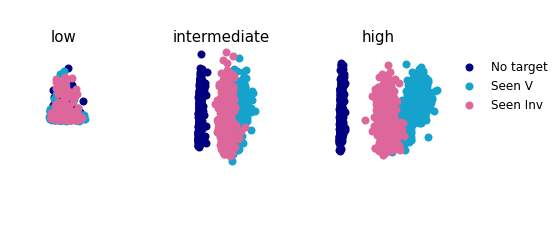

In [ ]:
fig = plt.figure(figsize=(8, 4))

for i_level in range(3):

  # Calculate mean or variance
  X = np.var(state_var_all[i_level], axis = 2)
  y = np.array(Label_Detection_all[i_level])
  model = PCA(n_components=2)
  X_r = model.fit_transform(X)

  # Percentage of variance explained for each components
  print('explained variance ratio (first two components): %s' % str(model.explained_variance_ratio_))
  target_names = ['No target', 'Seen V', 'Seen Inv']
  colors = ['navy', (21/255,163/255,205/255), (221/255,102/255,155/255)]
  lw = 2

  ax = fig.add_axes([0.1, 0.2, 0.6, 0.8])
  ax = plt.subplot(1,3,i_level+1)

  for color, i, target_name in zip(colors, [0, 1, 2], target_names):
      plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, lw=lw,
                  label=target_name)
  if i_level > 1:
    plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize = 12, frameon=False, bbox_to_anchor=(0.8, 0.7, 1., .1))

  plt.xlim(-3, 4)
  plt.ylim(-2, 2)

  plt.text(0, 1.3, targetlevel[i_level], ha='center', va='bottom', fontsize = 15)

  ax.axis('off')

  plt.savefig('./drive/MyDrive/Colab Notebooks/figure/pca.pdf',dpi = 300)

  # plt.locator_params(axis='y', nbins=2)
  # ax.tick_params(axis='both', which='major', labelsize=tick_font, length=1)
  #ax.spines["right"].set_visible(False)
  #ax.spines["top"].set_visible(False)
  #ax.xaxis.set_ticks_position('bottom')
  #ax.yaxis.set_ticks_position('left')
  # plt.setp(ax.get_xticklabels(), visible=False)

### t-SNE ploting

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.052701
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.633479
[t-SNE] KL divergence after 1000 iterations: 0.642798
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.112750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.906998
[t-SNE] KL divergence after 1000 iterations: 0.580040
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.114410
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.355724
[t-SNE] KL divergence after 1000 iterations: 0.464577


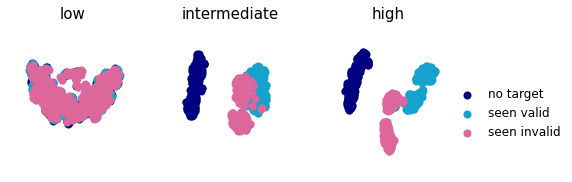

In [ ]:
fig = plt.figure(figsize=(8, 3))

for i_level in range(3):

  # Calculate mean or variance
  X = np.var(state_var_all[i_level], axis = 2)
  y = np.array(Label_Detection_all[i_level])
  model = TSNE(n_components=2, random_state=0, init='pca',
                          verbose=1, method='exact',
                          learning_rate=100, perplexity=30)
  X_r = model.fit_transform(X)

  # Percentage of variance explained for each components
  target_names = ['no target', 'seen valid', 'seen invalid']
  colors = ['navy', (21/255,163/255,205/255), (221/255,102/255,155/255)]
  lw = 2

  ax = fig.add_axes([0.2, 0.2, 0.6, 0.8])
  ax = plt.subplot(1,3,i_level+1)

  for color, i, target_name in zip(colors, [0, 1, 2], target_names):
      plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, lw=lw,
                  label=target_name)
  if i_level > 1:
    plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize = 12, frameon=False, bbox_to_anchor=(0.9, 0.5, 1., .1))

  plt.xlim(-90, 90)
  plt.ylim(-80, 80)

  plt.text(0, 70, targetlevel[i_level], ha='center', va='bottom', fontsize = 15)
  ax.axis('off')

plt.savefig('./drive/MyDrive/Colab Notebooks/figure/t-sne.pdf',dpi = 300)

In [ ]:
import sklearn

### Dynamic ploting

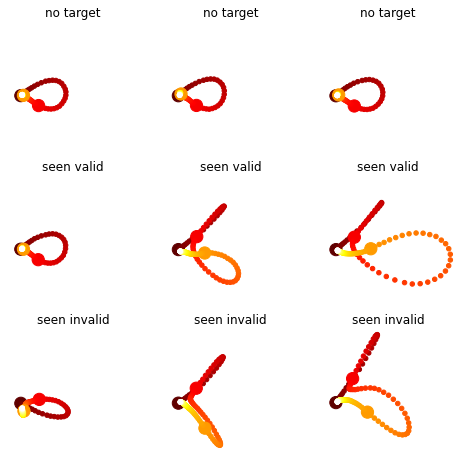

In [ ]:
fig = plt.figure(figsize=(8,8))
plot_order = [0,3,6,1,4,7,2,5,8]
count = 0

for i_level in range(3):
  for i, cond in enumerate(target_names):
    X = np.var(state_var_all[i_level], axis = 2)
    y = np.array(Label_Detection_all[i_level])
    X_i = X[y == i]

    # calculate PCA
    model = PCA(n_components = 2).fit(X_i.T)

    # visualize first and second PC
    W = model.components_
    pc_score = W @ X_i

    ax = fig.add_axes([0.3, 0.2, 0.6, 0.8])
    ax = plt.subplot(3,3,plot_order[count]+1)
    count+=1
    c = np.array(range(pc_score.shape[1]))
    s = np.ones(pc_score.shape[1]) * 20
    s[20] = 150;
    s[56] = 150;
    s[95] = 150;

    plt.scatter(pc_score[0,:],pc_score[1,:],s = s, c = c,marker='o' )
    cmap = plt.set_cmap('hot')

    plt.title(cond)
    plt.xlim([-2,18.8])
    plt.ylim([-1.5,2])
    ax.axis('off')

plt.savefig('./drive/MyDrive/Colab Notebooks/figure/dynamic.pdf',dpi = 300)


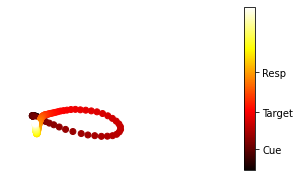

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))

X = np.var(state_var_all[0], axis = 2)
y = np.array(Label_Detection_all[0])
X_i = X[y == i]

# calculate PCA
model = PCA(n_components = 2).fit(X_i.T)

# visualize first and second PC
W = model.components_
pc_score = W @ X_i
cax = ax.scatter(pc_score[0,:],pc_score[1,:],c = np.array(range(pc_score.shape[1]))*10)
cmap = plt.set_cmap('hot')
plt.xlim([-2,17])
plt.ylim([-1,2])
ax.axis('off')
cbar = fig.colorbar(cax, ticks=[200, 560, 950], aspect = 15)
cbar.ax.set_yticklabels(['Cue', 'Target', 'Resp'])  # vertically oriented colorbar
plt.savefig('./drive/MyDrive/Colab Notebooks/figure/colorbar.pdf',dpi = 300)


## 6 - Trajectory k-mean method about temporal dynamics

### Prepare trials and k-means input

In [ ]:
# change the dim order of the input matrix -> Units * timesteps * conditions
state_var_reordered = np.transpose(state_var_concate, (2, 1, 0))

y_label = np.array(Label_Detection)
CombinedTrials = [np.mean(state_var_reordered[:,:,y_label == i_cond],axis = 2) for i_cond in range(3)]
keam_input_mat = np.transpose(CombinedTrials, (1,2,0))


## save to Matlab format
output_struct = {"data_mat":keam_input_mat,
                 "experiment": "exocos_RNN",
                 "state_var_units": state_var_concate,
                 "label_trial": Label_Detection,
                 "labels" : "0: no target, 1: Seen V, 2: Seen Iv"}

scipy.io.savemat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_output_trained0p1_target0p10Inter.mat', output_struct)

In [ ]:
id_clust = [2,4,2,2,1,3,1,1,4,1,5,1,2,5,4,2,2,4,5,2,1,1,2,5,2,5,2,1,4,4,5,2,2,2,2,2,2,5,5,3,2,2,1,4,2,4,2,3,1,1]

## 7 - PCA/t-SNE analysis on RNN cluster

In [ ]:
## load electrod id in each cluster, for reproductibility
id_clust = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/clust_id_0p10_k5.mat')['id'][0]
# id_clust = [2,4,2,2,1,3,1,1,4,1,5,1,2,5,4,2,2,4,5,2,1,1,2,5,2,5,2,1,4,4,5,2,2,2,2,2,2,5,5,3,2,2,1,4,2,4,2,3,1,1]


In [ ]:
#####
# generate test trial samples
#####

targetlevel = ["low","intermediate","high"]
this_targets = [0.01, 0.15, 0.30]  # probing contrast
Label_Detection_all = []
state_var_all = []

for this_target in this_targets:

  ExocosModel = ExogenousAttention(target_indensity= this_target, dt = dt, tau = tau, T = T, N_batch = N_batch, attention_gain = 1.5)
  # create labels and trials samples
  Label_Detection = []
  Label_Interaction = []
  state_var_concate = np.zeros((0,0,0))
  target_name = ['no target', 'seen valid', 'seen inv']

  # 0 : no target
  # 1 : detected / S V
  # 2 : detected / S Iv
  for trialblock in range(20):   # 20 blocks * 50 trials = 1000 trials
    x,y,m, trial_params = ExocosModel.get_trial_batch()
    # generate testing output from trained models
    output, state_var = basicModel.test(x)

    if trialblock == 0:
      state_var_concate = state_var
    else:
      state_var_concate = np.concatenate((state_var_concate,state_var),axis=0)

    for i, this_trial in enumerate(trial_params):
      if this_trial['detection'] == 0:
        Label_Detection.append(0)
      elif this_trial['cue_position'] == this_trial['target_position']:
        Label_Detection.append(1)
      else:
        Label_Detection.append(2)

  Label_Detection_all.append(Label_Detection)
  state_var_all.append(state_var_concate)

print(np.shape(Label_Detection_all))
print(np.shape(state_var_all))

(3, 1000)
(3, 1000, 160, 50)


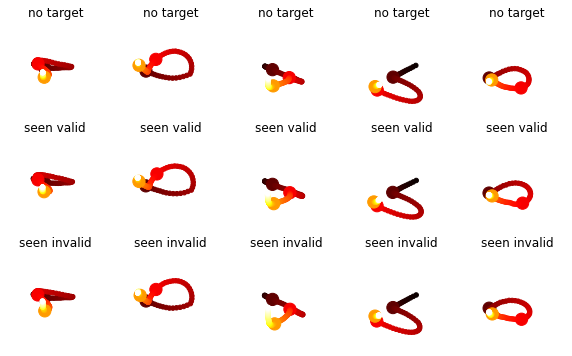

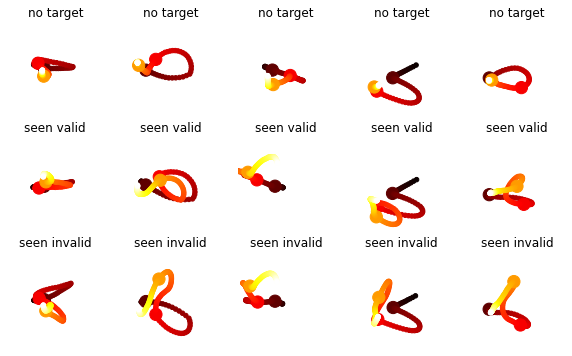

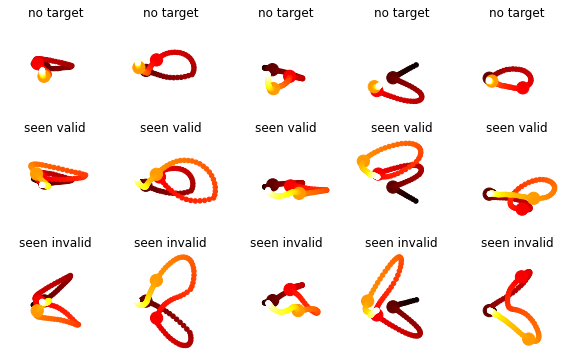

In [ ]:

plot_order = [0,5,10,1,6,11,2,7,12,3,8,13,4,9,14]

clust_to_plots = [5,2,4,1,3]
target_names = ['no target', 'seen valid', 'seen invalid']

for i_level in range(3):

  fig = plt.figure(figsize=(10,6))
  count = 0
  state_var_this_level = state_var_all[i_level]
  Label_Detection_this_level = Label_Detection_all[i_level]

  for i_cst, cst in enumerate(clust_to_plots):

    for i, cond in enumerate(target_names):
      X = np.mean(state_var_this_level[:,:,id_clust == cst], axis = 2)    # trial * time * units
      y = np.array(Label_Detection_this_level)
      X_i = X[y == i]

      # calculate PCA
      model = PCA(n_components = 2).fit(X_i.T)

      # visualize first and second PC
      W = model.components_
      pc_score = W @ X_i

      ax = fig.add_axes([0.2, 0.2, 0.6, 0.8])
      ax = plt.subplot(3,5,plot_order[count]+1)
      count+=1
      c = np.array(range(pc_score.shape[1]))
      s = np.ones(pc_score.shape[1]) * 20
      s[20] = 150;
      s[56] = 150;
      s[95] = 150;

      plt.scatter(pc_score[0,:],pc_score[1,:],s = s, c = c,marker='o' )
      cmap = plt.set_cmap('hot')

      plt.title(cond)

      plt.xlim([-10,13])
      plt.ylim([-4,4])

      if i_cst == 1:
        plt.xlim([-5,15])
        plt.ylim([-4,4])

      if i_cst == 2:
        plt.xlim([-10,17])
        plt.ylim([-4,4])

      if i_cst == 3:
        plt.xlim([-11,13])
        plt.ylim([-5,6])

      if i_cst == 4:
        plt.xlim([-8,35])
        plt.ylim([-4,6])
      ax.axis('off')

  plt.savefig('./drive/MyDrive/Colab Notebooks/figure/RNN_clust_dynamic' + str(this_targets[i_level]) + '.pdf',dpi = 300)

## 8 - lesion analysis by cluster


In [ ]:
id_clust = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/clust_id_0p10_k5.mat')['id'][0]
# clust ID for each units from clustering results, copy from Matlab
# id_clust = [2,4,2,2,1,3,1,1,4,1,5,1,2,5,4,2,2,4,5,2,1,1,2,5,2,5,2,1,4,4,5,2,2,2,2,2,2,5,5,3,2,2,1,4,2,4,2,3,1,1]

#### Accuracy for detection task

In [ ]:
#############################################
#
#  PLOT valid invalid and absent and all
#
#############################################
### find the accuracy of model for SEEN valid and invalid seperately, binary comparison

basicModel.destruct()

cst_to_plot = [0.01, 0.05, 0.10, 0.20, 0.30,0.4, 0.5, 0.6, 0.7]

acc_all = []

for i_cst, this_target_intensity in enumerate(cst_to_plot):
  print(this_target_intensity)
  # Define probing target intensity
  ExocosModel = ExogenousAttention(target_indensity= this_target_intensity, dt = dt, tau = tau, T = T, N_batch = N_batch, attention_gain = 1.5)

  # order [5,2,4,1,3]

  clust_to_lesion = [None,5,2,4,1,3]

  acc = []

  for id_n,this_clust in enumerate(clust_to_lesion):
    # import trained model by importing its weights
    load_network_params = network_params.copy()
    load_network_params['load_weights_path'] = "./drive/MyDrive/Colab Notebooks/TrainedModelStates/ExocosTrainedModels__I150000_Target0p10_Gain1p5_summary.npz"
    TrainedModel = Basic(load_network_params)
    weights = TrainedModel.get_weights()
    TrainedModel.destruct()

    load_network_params = network_params.copy()
    # get units index in this cluster
    if this_clust is None:
      unit_indices = None
    else:
      unit_indices = [index for index, element in enumerate(id_clust) if element == this_clust]

    # modify weights in these units and reload a modified model
    weights_mod = lesion_units(weights, unit_indices)
    np.savez('./weights/modified_saved_weights.npz', **weights_mod)
    load_network_params['load_weights_path'] = './weights/modified_saved_weights.npz'
    ModifiedModel = Basic(load_network_params)

    # assessing the accuracy of lesioned model
    acc.append(test_model_acc(ExocosModel, ModifiedModel)[0:2])

    # destruct model once used
    ModifiedModel.destruct()

  acc_all.append(acc)

## save to Matlab format
acc_detection_struct = {"data_mat":acc_all,
                 "task": "discrimination",
                 "labels" : "valid and invalid"}

scipy.io.savemat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_lesion_acc_detection.mat', acc_detection_struct)


0.01
0.05
0.1
0.2
0.3
0.4
0.5
0.6
0.7


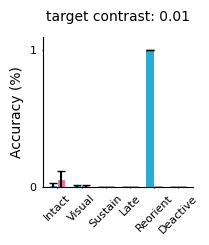

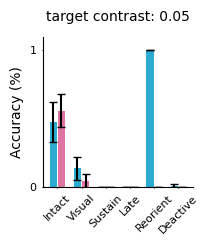

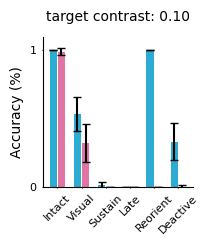

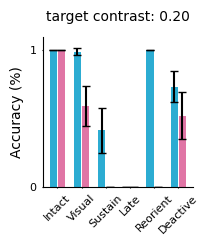

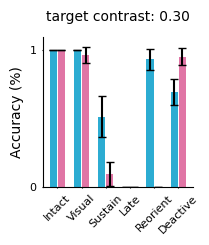

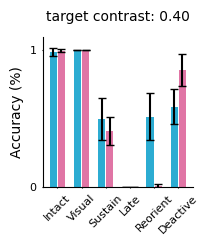

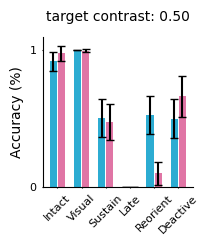

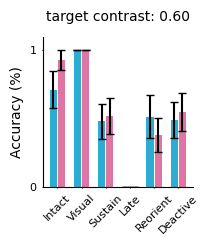

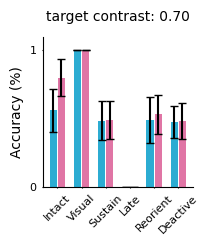

In [ ]:
acc_detect_raw = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_lesion_acc_detection.mat')
acc_detect = acc_detect_raw['data_mat']
np.shape(acc_detect)

clust_to_lesion = [None,5,2,4,1,3]
# cst_to_plot = [0.01, 0.05, 0.10, 0.20, 0.30,0.4, 0.5, 0.6, 0.7]
cst_to_plot = [0.01, 0.05, 0.10, 0.20, 0.30,0.4, 0.5, 0.6, 0.7]

for id_cst, this_cst in enumerate(cst_to_plot):
  ## Calculate the average and std
  acc = acc_detect[id_cst]
  acc_mean = np.mean(acc, axis = 2).reshape((1, np.size(clust_to_lesion) * 2 ))   # acc -> cluster * cond * block of 50
  acc_std  = np.std(acc, axis = 2).reshape((1, np.size(clust_to_lesion) * 2 ))

  # Define labels, positions, bar heights and error bar heights
  labels = ['Intact', 'Visual', 'Sustain', 'Late', 'Reorient', 'Deactive']
  label_pos = np.arange(np.size(clust_to_lesion)) + 1

  x_pos = [(i+1-0.17,i+1+0.17) for i in range(len(clust_to_lesion))]
  x_pos = np.array(x_pos).reshape((1, np.size(clust_to_lesion) * 2 ))[0]

  CTEs = acc_mean[0]
  error = acc_std[0]

  # Build the plot
  fig = plt.figure(figsize=(2.5,2.5))
  ax = fig.add_axes([0.3,0.27, 0.6, 0.6])

  ax.bar(x_pos, CTEs,
        yerr=error,
        align='center',
        width=0.3,
        alpha=0.9,
        color = [(21/255,163/255,205/255), (221/255,102/255,155/255),(21/255,163/255,205/255), (221/255,102/255,155/255),
                  (21/255,163/255,205/255), (221/255,102/255,155/255),(21/255,163/255,205/255), (221/255,102/255,155/255),
                  (21/255,163/255,205/255), (221/255,102/255,155/255)],
        ecolor='black',
        capsize= 3)

  text_font = 10

  ax.set_xticks(label_pos)
  ax.set_xticklabels(labels, rotation = 45)

  plt.ylabel('Accuracy (%)', fontsize=text_font)
  plt.title('target contrast: ' + "{:.2f}".format(this_cst), fontsize=text_font, y=1.05)
  plt.locator_params(axis='y', nbins=2)
  ax.tick_params(axis='both', which='major', labelsize=8, length=1)
  ax.spines["right"].set_visible(False)
  ax.spines["top"].set_visible(False)
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

  ax.yaxis.grid(False)
  plt.ylim([0, 1.1])

  # plt.savefig('./drive/MyDrive/Colab Notebooks/figure/Lesion_performance_detection_' + "{:.2f}".format(this_cst) + '.pdf', dpi = 300)


In [ ]:
acc_detect_raw = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_lesion_acc_detection.mat')
acc_detect = acc_detect_raw['data_mat']
np.shape(acc_detect)

clust_to_lesion = [None,5,2,4,1,3]
cst_to_plot = [0.01, 0.05, 0.10, 0.20, 0.30,0.4, 0.5, 0.6, 0.7]

for id_cst, this_cst in enumerate(cst_to_plot):
  ## Calculate the average and std
  if this_cst == 0.4:
    acc = acc_detect[id_cst]
    acc_mean = np.mean(acc, axis = 2).reshape((1, np.size(clust_to_lesion) * 2 ))   # acc -> cluster * cond * block of 50
    acc_std  = np.std(acc, axis = 2).reshape((1, np.size(clust_to_lesion) * 2 ))

    # Define labels, positions, bar heights and error bar heights
    labels = ['Intact', 'Visual', 'Sustain', 'Late', 'Reorient', 'Deactive']
    acc_rearrange = np.array([acc[0,0,:],acc[0,1,:],acc[1,0,:],acc[1,1,:],acc[2,0,:],acc[2,1,:],acc[3,0,:],acc[3,1,:],acc[4,0,:],acc[4,1,:],acc[5,0,:],acc[5,1,:]])
    np.shape(acc_rearrange.transpose())
    print(np.mean(acc_rearrange,axis = 1))
    np.savetxt("./drive/MyDrive/Colab Notebooks/figure/detection04_.csv", acc_rearrange.transpose(), delimiter=",")

[0.98778419 0.99866667 1.         1.         0.49687127 0.4105461
 0.         0.         0.51497561 0.00518838 0.58775444 0.85850984]


#### Accuracy for discrimination task

In [ ]:
### find the accuracy of model for SEEN valid and invalid seperately, binary comparison

basicModel.destruct()

cst_to_plot = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40,0.5,0.6,0.7]

acc_all = []

for i_cst, this_target_intensity in enumerate(cst_to_plot): # 0.02,0.05,0.06,0.08,0.10,0.15,0.2,0.3,0.40
  print(this_target_intensity)
  # Define probing target intensity
  ExocosModel = ExogenousAttention(target_indensity= this_target_intensity, dt = dt, tau = tau, T = T, N_batch = N_batch, attention_gain = 1.5)

  # order [5,2,4,1,3]
  clust_to_lesion = [None,5,2,4,1,3]

  acc = []

  for id_n,this_clust in enumerate(clust_to_lesion):
    # import trained model by importing its weights
    load_network_params = network_params.copy()
    load_network_params['load_weights_path'] = "./drive/MyDrive/Colab Notebooks/TrainedModelStates/ExocosTrainedModels__I150000_Target0p10_Gain1p5_summary.npz"
    TrainedModel = Basic(load_network_params)
    weights = TrainedModel.get_weights()
    TrainedModel.destruct()

    load_network_params = network_params.copy()
    # get units index in this cluster
    if this_clust is None:
      unit_indices = None
    else:
      unit_indices = [index for index, element in enumerate(id_clust) if element == this_clust]

    # modify weights in these units and reload a modified model
    weights_mod = lesion_units(weights, unit_indices)
    np.savez('./weights/modified_saved_weights.npz', **weights_mod)
    load_network_params['load_weights_path'] = './weights/modified_saved_weights.npz'
    ModifiedModel = Basic(load_network_params)

    # assessing the accuracy of lesioned model
    acc.append(test_model_acc_seen(ExocosModel, ModifiedModel))

    # destruct model once used
    ModifiedModel.destruct()

  acc_all.append(acc)

## save to Matlab format
acc_discrimination_struct = {"data_mat":acc_all,
                 "task": "discrimination",
                 "labels" : "valid and invalid"}

scipy.io.savemat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_lesion_acc_discrimination.mat', acc_discrimination_struct)

0.01
0.05
0.1
0.2
0.3
0.4
0.5
0.6
0.7


(9, 6, 2, 50)


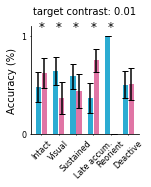

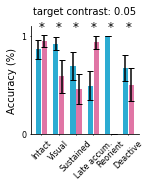

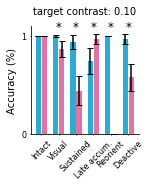

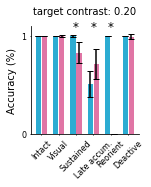

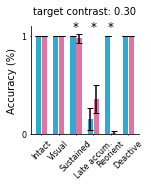

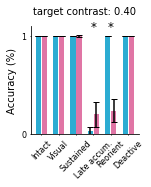

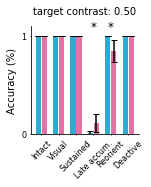

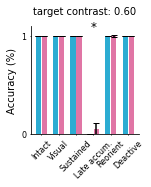

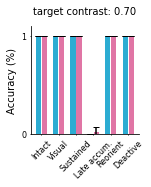

In [ ]:
acc_discri_raw = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/Exocos_RNN_lesion_acc_discrimination.mat')
acc_discri = acc_discri_raw['data_mat']
print(np.shape(acc_discri))

cst_to_plot = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40,0.5,0.6,0.7]

for id_cst, this_cst in enumerate(cst_to_plot):
  ## Calculate the average and std
  acc = acc_discri[id_cst]
  acc_mean = np.mean(acc, axis = 2).reshape((1, np.size(clust_to_lesion) * 2 ))   # acc -> cluster * cond * block of 50
  acc_std  = np.std(acc, axis = 2).reshape((1, np.size(clust_to_lesion) * 2 ))

  # Define labels, positions, bar heights and error bar heights
  labels = ['Intact', 'Visual', 'Sustained', 'Late accum.', 'Reorient', 'Deactive']
  label_pos = np.arange(np.size(clust_to_lesion)) + 1

  x_pos = [(i+1-0.17,i+1+0.17) for i in range(len(clust_to_lesion))]
  x_pos = np.array(x_pos).reshape((1, np.size(clust_to_lesion) * 2 ))[0]

  CTEs = acc_mean[0]
  error = acc_std[0]

  # Build the plot
  fig = plt.figure(figsize=(2.5,2.5))
  ax = fig.add_axes([0.3,0.27, 0.6, 0.6])

  ax.bar(x_pos, CTEs,
        yerr=error,
        align='center',
        width=0.3,
        alpha=0.9,
        color = [(21/255,163/255,205/255), (221/255,102/255,155/255),(21/255,163/255,205/255), (221/255,102/255,155/255),
                  (21/255,163/255,205/255), (221/255,102/255,155/255),(21/255,163/255,205/255), (221/255,102/255,155/255),
                  (21/255,163/255,205/255), (221/255,102/255,155/255)],
        ecolor='black',
        capsize= 3)

  text_font = 10

  ax.set_xticks(label_pos)
  ax.set_xticklabels(labels, rotation = 45)

  plt.ylabel('Accuracy (%)', fontsize=text_font)
  plt.title('target contrast: ' + "{:.2f}".format(this_cst), fontsize=text_font, y=1.05)
  plt.locator_params(axis='y', nbins=2)
  ax.tick_params(axis='both', which='major', labelsize=8, length=1)
  ax.spines["right"].set_visible(False)
  ax.spines["top"].set_visible(False)
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

  ax.yaxis.grid(False)
  plt.ylim([0, 1.1])

  ###################################################################################
  ## Statistical testing
  for i_c in range(np.size(clust_to_lesion)):
    s_p = stats.ttest_ind(acc[i_c][0], acc[i_c][1]).pvalue
    multicorrection = 6 * 50
    fsize = 12
    if  s_p < 0.001 / multicorrection :
      mark_s = "*"
      plt.text(i_c+1 , 1.02, mark_s, ha='center', va='bottom', fontsize = fsize)
    elif s_p < 0.01 / multicorrection :
      mark_s = "*"
      plt.text(i_c+1 , 1.02, mark_s, ha='center', va='bottom', fontsize = fsize)
    elif s_p < 0.05 / multicorrection :
      mark_s = "*"
      plt.text(i_c+1 , 1.02, mark_s, ha='center', va='bottom', fontsize = fsize)
  ###################################################################################

  plt.savefig('./drive/MyDrive/Colab Notebooks/figure/Lesion_performance_discrimination' + "{:.2f}".format(this_cst) + '.pdf', dpi = 300)


# 9 - Network structure analysis


### Anatomical : connection weight

In [ ]:
from matplotlib.colors import Normalize
import scipy.stats as stats
import scipy.io

def plot_weights(weights, title=""):
    cmap = plt.set_cmap('RdBu_r')
    img = plt.matshow(weights, norm=Normalize(vmin=-.5, vmax=.5))
    plt.title(title)
    plt.colorbar()
    plt.xticks([8, 24, 28, 34, 36, 44, 47, 49, 50], ['Visual', 'Sustain_E','Sustain_I', 'Late_E','Late_I', 'Reorient_E','Reorient_I', 'Decreased_E','Decreased_I'], rotation=45)
    plt.yticks([8, 24, 28, 34, 36, 44, 47, 49, 50], ['Visual', 'Sustain_E','Sustain_I', 'Late_E','Late_I', 'Reorient_E','Reorient_I', 'Decreased_E','Decreased_I'], rotation=0)

In [ ]:
## load a trained model
# basicModel.destruct()
load_network_params = network_params.copy()
load_network_params['load_weights_path'] = './drive/MyDrive/Colab Notebooks/TrainedModelStates/ExocosTrainedModels__I150000_' + 'Target0p10_Gain1p5_summary' + '.npz'

basicModel = Basic(load_network_params)

In [ ]:
## load clustering index for each unit
id_clust = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/clust_id_0p10_k5.mat')['id'][0].astype(np.float32)
id_clust[40:50] = id_clust[40:50] + 0.5  # to seperate inhibitory (+0.5) and excitatory
#clust_to_lesion = [5,2,4,1,3]
#labels = ['Visual', 'Sustain', 'Late', 'Reorient', 'Decreased']

# reorder clustering order as label order
id_clust[id_clust == 1] = 6
id_clust[id_clust == 5] = 1
id_clust[id_clust == 3] = 5
id_clust[id_clust == 4] = 3
id_clust[id_clust == 6] = 4

id_clust[id_clust == 1.5] = 6.5
id_clust[id_clust == 5.5] = 1.5
id_clust[id_clust == 3.5] = 5.5
id_clust[id_clust == 4.5] = 3.5
id_clust[id_clust == 6.5] = 4.5

<Figure size 432x288 with 0 Axes>

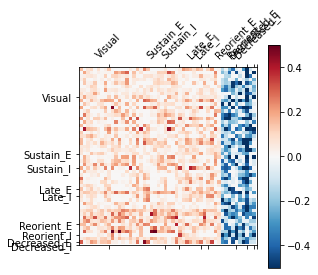

In [ ]:
weights = basicModel.get_weights()
plot_weights(weights['W_rec'])

<Figure size 432x288 with 0 Axes>

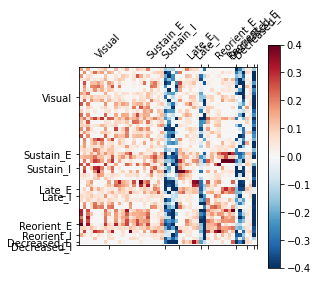

In [ ]:
def sort_corr_index(r, idx_sort):
  nb_unit = np.shape(idx_sort)[0]
  sorted_mat = np.zeros((nb_unit, nb_unit))
  for i in range(nb_unit):
      idx = idx_sort[i]
      for j in range(nb_unit):
          idx2 = idx_sort[j]
          sorted_mat[i,j] = r[idx,idx2]
  return sorted_mat

idx_sort = np.argsort(id_clust)
w_rec_sorted = sort_corr_index(weights['W_rec'], idx_sort)
plot_weights(w_rec_sorted)
plt.clim(-0.4,0.4)

<Figure size 432x288 with 0 Axes>

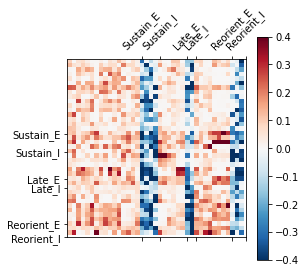

In [ ]:
cmap = plt.set_cmap('RdBu_r')
img = plt.matshow(w_rec_sorted[8:47,8:47], norm=Normalize(vmin=-.5, vmax=.5))
plt.colorbar()
FP_tick = np.array([24, 28, 34, 36, 44, 47]) - 8
plt.xticks(FP_tick, ['Sustain_E','Sustain_I', 'Late_E','Late_I', 'Reorient_E','Reorient_I'], rotation=45)
plt.yticks(FP_tick, ['Sustain_E','Sustain_I', 'Late_E','Late_I', 'Reorient_E','Reorient_I'], rotation=0)
plt.clim(-0.4,0.4)
plt.savefig('./drive/MyDrive/Colab Notebooks/figure/RNN_E_I_recurrent_weight.pdf', dpi = 300)

In [ ]:
# !pip install statsmodels
import statsmodels.stats.multitest as mlt

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


([<matplotlib.axis.YTick at 0x7f8efd4ae610>,
 [Text(0, 0, 'Sustain_E'),
  Text(0, 0, 'Sustain_I'),
  Text(0, 0, 'Late_E'),
  Text(0, 0, 'Late_I'),
  Text(0, 0, 'Reorient_E'),
  Text(0, 0, 'Reorient_I')])

<Figure size 432x288 with 0 Axes>

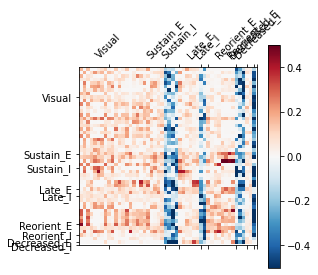

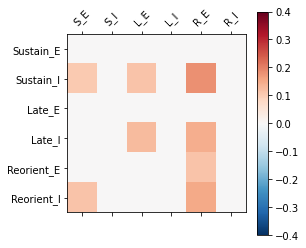

In [ ]:
## visualization seperate plot inhibitory and excitatory figures
# plot excitatory
w_rec_exci = w_rec_sorted.copy()
# threshold_value = w_rec_exci[ w_rec_exci > 0].mean() + 3*  np.std(w_rec_exci[ w_rec_exci > 0])
threshold_value = w_rec_exci[ w_rec_exci > 0].mean()

# w_rec_exci[ w_rec_exci < threshold_value] = 0
plot_weights(w_rec_exci)

nb_unit_clust = [8, 16, 4, 6, 2, 8, 3, 2, 1]  # nb of unit in each cluster
nb_clust      = len(nb_unit_clust)
Exci_weight   = np.zeros((nb_clust,nb_clust))
Exci_weight_p = np.zeros((nb_clust,nb_clust))

idx_x_start = 0          # the row
idx_x_end   = 0          # the row
idx_y_start = 0          # the columne
idx_y_end   = 0          # the columne

for i, nb_unit in enumerate(nb_unit_clust):
    idx_x_start   = idx_x_start
    idx_x_end     = idx_x_start + nb_unit

    for j in range(len(nb_unit_clust)):
      idx_y_start   = idx_y_start
      idx_y_end     = idx_y_start + nb_unit_clust[j]
      Exci_tmp = w_rec_exci[idx_x_start:idx_x_end, idx_y_start:idx_y_end]
      Exci_weight_p[i,j] = stats.ttest_1samp(a= Exci_tmp.flatten(), popmean= threshold_value, alternative = 'greater').pvalue   # perform one sample t-test
      Exci_weight[i,j] = Exci_tmp.mean()
      idx_y_start   = idx_y_start + nb_unit_clust[j]

    idx_y_start   = 0
    idx_x_start   = idx_x_start + nb_unit

## multicorrection with holm-bofferoni correction
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html


Exci_weight_FP = Exci_weight[1:7,1:7]
Exci_weight_FP_p = Exci_weight_p[1:7,1:7]

[rej, pvals_corrected, alphacSidak,alphacBonf] = mlt.multipletests(Exci_weight_FP_p, alpha=0.05, method='holm-sidak')

Exci_weight_FP_copy = Exci_weight_FP.copy()

Exci_weight_FP[Exci_weight_FP_p > alphacBonf] = 0

Exci_weight_FP[Exci_weight_FP<0] =0

cmap = plt.set_cmap('RdBu_r')
img = plt.matshow(Exci_weight_FP, norm=Normalize(vmin=-.2, vmax=.2))
plt.colorbar()
plt.clim(-0.4,0.4)
xlab  = np.arange(6)
plt.xticks(xlab,['S_E','S_I', 'L_E','L_I', 'R_E','R_I'], rotation = 45)
plt.yticks(xlab,['Sustain_E','Sustain_I', 'Late_E','Late_I', 'Reorient_E','Reorient_I'])

([<matplotlib.axis.YTick at 0x7fb4cff38e10>,
 [Text(0, 0, 'Visual'),
  Text(0, 0, 'Sustain_E'),
  Text(0, 0, 'Sustain_I'),
  Text(0, 0, 'Late_E'),
  Text(0, 0, 'Late_I'),
  Text(0, 0, 'Reorient_E'),
  Text(0, 0, 'Reorient_I'),
  Text(0, 0, 'Decreased_E'),
  Text(0, 0, 'Decreased_I')])

<Figure size 144x216 with 0 Axes>

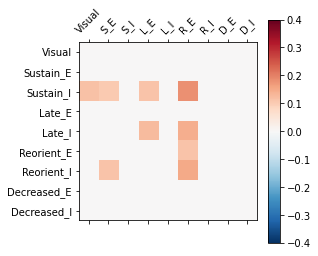

In [ ]:
## use 9*9 as multicorrection test
[rej, pvals_corrected, alphacSidak,alphacBonf] = mlt.multipletests(Exci_weight_p, alpha=0.05, method='holm-sidak')

Exci_weight_copy = Exci_weight.copy()

Exci_weight[Exci_weight_p > alphacBonf] = 0

Exci_weight[Exci_weight<0] =0

cmap = plt.set_cmap('RdBu_r')
img = plt.matshow(Exci_weight, norm=Normalize(vmin=-.2, vmax=.2))
plt.colorbar()
plt.clim(-0.4,0.4)
xlab  = np.arange(9)
plt.xticks(xlab,['Visual', 'S_E','S_I', 'L_E','L_I', 'R_E','R_I', 'D_E','D_I'], rotation = 45)
plt.yticks(xlab,['Visual', 'Sustain_E','Sustain_I', 'Late_E','Late_I', 'Reorient_E','Reorient_I', 'Decreased_E','Decreased_I'])

([<matplotlib.axis.YTick at 0x7fb4d0a78290>,
 [Text(0, 0, 'Sustain_E'),
  Text(0, 0, 'Sustain_I'),
  Text(0, 0, 'Late_E'),
  Text(0, 0, 'Late_I'),
  Text(0, 0, 'Reorient_E'),
  Text(0, 0, 'Reorient_I')])

<Figure size 144x216 with 0 Axes>

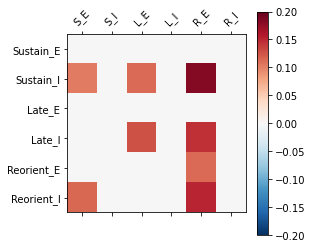

In [ ]:
Exci_weight_FP = Exci_weight[1:7,1:7]

cmap = plt.set_cmap('RdBu_r')
img = plt.matshow(Exci_weight_FP, norm=Normalize(vmin=-.2, vmax=.2))
plt.colorbar()
xlab  = np.arange(6)
plt.xticks(xlab,['S_E','S_I', 'L_E','L_I', 'R_E','R_I'], rotation = 45)
plt.yticks(xlab,['Sustain_E','Sustain_I', 'Late_E','Late_I', 'Reorient_E','Reorient_I'])

In [ ]:
Exci_weight_FP

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.10386176, 0.        , 0.11403773, 0.        , 0.18305661,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.12696226, 0.        , 0.14646889,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.11379064,
        0.        ],
       [0.1150189 , 0.        , 0.        , 0.        , 0.1526989 ,
        0.        ]])

0.005555555555555556


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


([<matplotlib.axis.YTick at 0x7fb4d28f65d0>,
 [Text(0, 0, 'Visual'),
  Text(0, 0, 'Sustain_E'),
  Text(0, 0, 'Sustain_I'),
  Text(0, 0, 'Late_E'),
  Text(0, 0, 'Late_I'),
  Text(0, 0, 'Reorient_E'),
  Text(0, 0, 'Reorient_I'),
  Text(0, 0, 'Decreased_E'),
  Text(0, 0, 'Decreased_I')])

<Figure size 144x216 with 0 Axes>

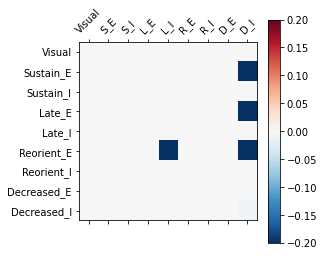

In [ ]:
## visualization seperate plot inhibitory and excitatory figures
# plot inhibitory
w_rec_inhi = w_rec_sorted.copy()
threshold_value = w_rec_inhi[ w_rec_inhi < 0].mean()

w_rec_inhi[w_rec_inhi > 0 ] = 0

nb_unit_clust = [8, 16, 4, 6, 2, 8, 3, 2, 1]  # nb of unit in each cluster
nb_clust      = len(nb_unit_clust)
Inhi_weight   = np.zeros((nb_clust,nb_clust))
Inhi_weight_p = np.zeros((nb_clust,nb_clust))

idx_x_start = 0          # the row
idx_x_end   = 0          # the row
idx_y_start = 0          # the columne
idx_y_end   = 0          # the columne

for i, nb_unit in enumerate(nb_unit_clust):
    idx_x_start   = idx_x_start
    idx_x_end     = idx_x_start + nb_unit

    for j in range(len(nb_unit_clust)):
      idx_y_start   = idx_y_start
      idx_y_end     = idx_y_start + nb_unit_clust[j]
      Inhi_tmp = w_rec_inhi[idx_x_start:idx_x_end, idx_y_start:idx_y_end]
      Inhi_weight_p[i,j] = stats.ttest_1samp(a= Inhi_tmp.flatten(), popmean= threshold_value, alternative = 'less').pvalue   # perform one sample t-test
      Inhi_weight[i,j] = Inhi_tmp.mean()
      idx_y_start   = idx_y_start + nb_unit_clust[j]

    idx_y_start   = 0
    idx_x_start   = idx_x_start + nb_unit

## multicorrection with holm-bofferoni correction
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html

[rej, pvals_corrected, alphacSidak,alphacBonf] = mlt.multipletests(Inhi_weight_p, alpha=0.05, method='hs')

Inhi_weight[Inhi_weight_p > alphacBonf] = 0
print(alphacBonf)
Inhi_weight[Inhi_weight>0] =0

cmap = plt.set_cmap('RdBu_r')
img = plt.matshow(Inhi_weight, norm=Normalize(vmin=-.2, vmax=.2))
plt.colorbar()

xlab  = np.arange(9)
plt.xticks(xlab,['Visual', 'S_E','S_I', 'L_E','L_I', 'R_E','R_I', 'D_E','D_I'], rotation = 45)
plt.yticks(xlab,['Visual', 'Sustain_E','Sustain_I', 'Late_E','Late_I', 'Reorient_E','Reorient_I', 'Decreased_E','Decreased_I'])

In [ ]:
Inhi_weight

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.40812877],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.73118047],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.39366543,
         0.        ,  0.        ,  0.        , -0.54819757],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

In [ ]:
## statistical test of input and output connections
W_in_sorted = weights['W_in'][idx_sort]
W_out_sorted = np.transpose(weights['W_out'])[idx_sort]

array([0.87868893, 0.85662705, 0.        , 0.        , 0.        ,
       0.34869659, 0.        , 0.        , 0.        ])

<Figure size 288x216 with 0 Axes>

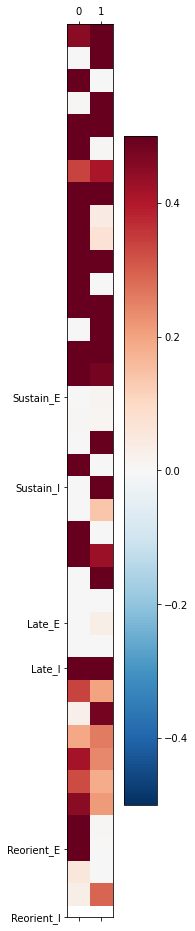

In [ ]:
fig = plt.figure(figsize=(4, 3))

cmap = plt.set_cmap('RdBu_r')
img = plt.matshow(W_in_sorted[8:47], norm=Normalize(vmin=-.5, vmax=.5))
plt.colorbar()
plt.yticks(FP_tick, ['Sustain_E','Sustain_I', 'Late_E','Late_I', 'Reorient_E','Reorient_I'], rotation=0)
plt.clim(-0.5,0.5)
plt.savefig('./drive/MyDrive/Colab Notebooks/figure/RNN_E_I_input_weight.pdf', dpi = 300)

W_in_p = np.zeros(9)
W_in_mean = np.zeros(9)

idx_start = 0

for i, nb_u in enumerate(nb_unit_clust):
  W_in_p[i] = stats.ttest_1samp(a= W_in_sorted[idx_start:idx_start+nb_u].flatten(), popmean= 0).pvalue
  W_in_mean[i] = W_in_sorted[idx_start:idx_start+nb_u].mean()
  idx_start = idx_start + nb_u

[rej, pvals_corrected_in, alphacSidak,alphacBonf_in] = mlt.multipletests(W_in_p, alpha=0.05, method='holm-sidak')

W_in_mean[pvals_corrected_in > 0.05] = 0
W_in_mean

array([0.        , 0.        , 0.13207324, 0.        , 0.        ,
       0.        ])

<Figure size 144x216 with 0 Axes>

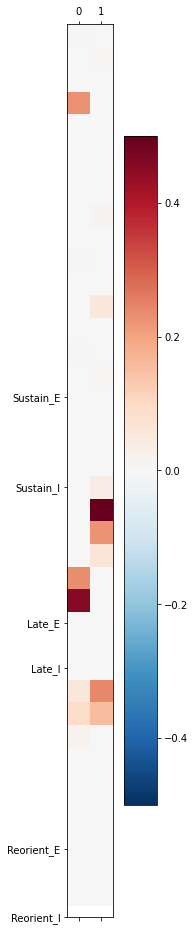

In [ ]:
cmap = plt.set_cmap('RdBu_r')
img = plt.matshow(W_out_sorted[8:47], norm=Normalize(vmin=-.5, vmax=.5))
plt.colorbar()
plt.yticks(FP_tick, ['Sustain_E','Sustain_I', 'Late_E','Late_I', 'Reorient_E','Reorient_I'], rotation=0)
plt.clim(-0.5,0.5)
plt.savefig('./drive/MyDrive/Colab Notebooks/figure/RNN_E_I_output_weight.pdf', dpi = 300)

W_out_p = np.zeros(9)
W_out_mean = np.zeros(9)

idx_start = 0

for i, nb_u in enumerate(nb_unit_clust):
  W_out_p[i] = stats.ttest_1samp(a= W_out_sorted[idx_start:idx_start+nb_u].flatten(), popmean= 0).pvalue
  W_out_mean[i] = W_out_sorted[idx_start:idx_start+nb_u].mean()
  idx_start = idx_start + nb_u

# [rej, pvals_corrected_out, alphacSidak,alphacBonf_out] = mlt.multipletests(W_out_p, alpha=0.05, method='holm-sidak')

W_out_mean[W_out_p > 0.05] = 0
W_out_mean[1:7]

In [ ]:
W_out_p

array([0.01658321, 0.14203002,        nan, 0.04145166,        nan,
       0.05828828,        nan, 0.10857388,        nan])

## Functional : global ignition of response

In [ ]:
dt = 10 # The simulation timestep.
tau = 100 # The intrinsic time constant of neural state decay.
T = 1600 # The trial length.
N_batch = 50 # The number of trials per training update.
N_rec = 50 # The number of recurrent units in the network.
name = 'ExocosModel' #  Unique name used to determine variable scope for internal use.

## load a trained model
# TrainedModel.destruct()
load_network_params = network_params.copy()
load_network_params['load_weights_path'] = './drive/MyDrive/Colab Notebooks/TrainedModelStates/ExocosTrainedModels__I150000_' + 'Target0p10_Gain1p5_summary' + '.npz'
TrainedModel = Basic(load_network_params)

## load cluster id
id_clust = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/TrainedModelStates/clust_id_0p10_k5.mat')['id'][0]


In [ ]:
basicModel.destruct()

In [ ]:
clust_ignition = [5,2,4,1]
labels = ['Visual','Sustain', 'Late', 'Reorient']

target_indensities = np.arange(0.00,0.12,0.01)

V_contrast_peak_raw = []
Inv_contrast_peak_raw = []
Abs_contrast_peak_raw = []

for this_target_indensity in target_indensities:
  print("computing: " + "{:.2f}".format(this_target_indensity))
  ExocosModel = ExogenousAttention(dt = dt, tau = tau, T = T, N_batch = N_batch, target_indensity = this_target_indensity) # Initialize the task object

  ### Cluster activation
  V_contrast_peak_batch = []
  Inv_contrast_peak_batch = []
  Abs_contrast_peak_batch = []

  for i_batch in range(20):# (1,50):
    x,y,m, trial_params = ExocosModel.get_trial_batch()
    output, state_var = TrainedModel.test(x)

    # find index for each trial condition
    V_idx = [];
    Inv_idx = [];
    Abs_idx = [];
    for i in range(50):
      if trial_params[i]['detection'] == 0:
        Abs_idx.append(i)
      elif trial_params[i]['cue_position'] == trial_params[i]['target_position']:
        V_idx.append(i)
      else:
        Inv_idx.append(i)
    V_units_peak = np.mean(state_var[V_idx,60:100,:], axis=1)               #-> V_units_peak: trial * 50 units
    Inv_units_peak = np.mean(state_var[Inv_idx,60:100,:], axis=1)
    Abs_units_peak = np.mean(state_var[Abs_idx,60:100,:], axis=1)
    # find index for each cluster
    V_units_peak_cluster = []
    Inv_units_peak_cluster = []
    Abs_units_peak_cluster = []
    for this_cluster in clust_ignition:
        unit_indices = [index for index, element in enumerate(id_clust) if element == this_cluster]
        V_units_peak_cluster.append(np.mean(V_units_peak[:,unit_indices]))       # -> trial one value for each cluster n*1
        Inv_units_peak_cluster.append(np.mean(Inv_units_peak[:,unit_indices]))   # -> trial one value for each cluster n*1
        Abs_units_peak_cluster.append(np.mean(Abs_units_peak[:,unit_indices]))   # -> trial one value for each cluster n*1

    V_contrast_peak_batch.append(V_units_peak_cluster)
    Inv_contrast_peak_batch.append(Inv_units_peak_cluster)
    Abs_contrast_peak_batch.append(Abs_units_peak_cluster)

  V_contrast_peak_raw.append(V_contrast_peak_batch)
  Inv_contrast_peak_raw.append(Inv_contrast_peak_batch)
  Abs_contrast_peak_raw.append(Abs_contrast_peak_batch)

V_contrast_peak = np.mean(V_contrast_peak_raw, axis = 1)
Inv_contrast_peak = np.mean(Inv_contrast_peak_raw, axis = 1)
Abs_contrast_peak = np.mean(Abs_contrast_peak_raw, axis = 1)


computing: 0.00
computing: 0.01
computing: 0.02
computing: 0.03
computing: 0.04
computing: 0.05
computing: 0.06
computing: 0.07
computing: 0.08
computing: 0.09
computing: 0.10
computing: 0.11


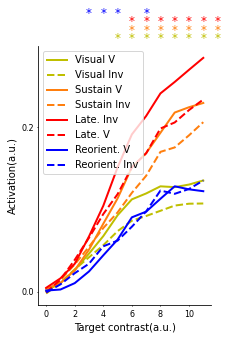

In [ ]:
data_v_peak = V_contrast_peak.copy()
data_inv_peak = Inv_contrast_peak.copy()
data_abs_peak = Abs_contrast_peak.copy()

v = (np.array(data_v_peak) - np.mean(data_abs_peak, axis= 0))
inv = (np.array(data_inv_peak) - np.mean(data_abs_peak, axis= 0))


fig = plt.figure(figsize=(4, 6))
ax = fig.add_axes([0.3,0.2, 0.6, 0.6])
colors = ['y','C1','r','b']
labels = ['Visual v','Sustain V', 'Late V', 'Reorient V','Visual inv', 'Sustain Inv', 'Late Inv','Reorient Inv']

import statsmodels.stats.multitest as mlt


for i in range(4):
  ax.plot(v[:,i], '-', color = colors[i], label = labels[i], linewidth=2)
  ax.plot(inv[:,i], '--', color = colors[i], label = labels[i], linewidth=2)

  ###################################################################################
  ## Statistical testing
  for i_c in range(np.shape(V_contrast_peak)[0]):
    s_p = stats.ttest_ind(np.transpose(V_contrast_peak_raw[i_c])[i], np.transpose(Inv_contrast_peak_raw[i_c])[i]).pvalue
    [rej, pvals_corrected, alphacSidak,alphacBonf] = mlt.multipletests(s_p, alpha=0.05, method='holm-sidak')

    fsize = 12
    if pvals_corrected < 0.05 :
      mark_s = "*"
      plt.text(i_c+1 , 0.3 + 0.01 * i, mark_s, ha='center', va='bottom', fontsize = fsize, color = colors[i])
  ###################################################################################


text_font = 10
plt.xlabel('Target contrast(a.u.)', fontsize=text_font)
plt.ylabel('Activation(a.u.)', fontsize=text_font)
plt.locator_params(axis='y', nbins=2)
ax.tick_params(axis='both', which='major', labelsize=8, length=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.legend( ['Visual V','Visual Inv','Sustain V', 'Sustain Inv', 'Late. Inv', 'Late. V','Reorient. V','Reorient. Inv'])

# plt.savefig('./drive/MyDrive/Colab Notebooks/figure/RNN_cluster_activation_contrast.pdf', dpi = 300)


In [ ]:
data_v_peak = V_contrast_peak.copy()
data_inv_peak = Inv_contrast_peak.copy()
data_abs_peak = Abs_contrast_peak.copy()

v = (np.array(data_v_peak) - np.mean(data_abs_peak, axis= 0))
inv = (np.array(data_inv_peak) - np.mean(data_abs_peak, axis= 0))

np.savetxt("./drive/MyDrive/Colab Notebooks/figure/fig4e_v.csv", v, delimiter=",")
np.savetxt("./drive/MyDrive/Colab Notebooks/figure/fig4e_iv.csv", inv, delimiter=",")


# 10 -NeuroData PCA visualization

In [ ]:
ls

drive/  sample_data/  weights/


In [ ]:
SEEG_Raw = []
import scipy.io
SEEG_Raw = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/sEEGdata/HFBB_allpp_Elec_time_cond_norm.mat')
clust_id_raw = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/sEEGdata/clust_id_k10.mat')
clust_id = clust_id_raw['id'][0]
print(np.shape(clust_id))

(727,)


In [ ]:
Elec_time_cond = SEEG_Raw['Elec_time_cond']
print(np.shape(Elec_time_cond))
Cond_time_elec = np.transpose(Elec_time_cond, (2, 1, 0))
print(np.shape(Cond_time_elec))

# Label_seeg_all = [1,0,1,0,1,0,1,0,] # seen vs unseen
Label_seeg_all = [1,1,0,0,1,1,0,0,] # valid vs invalid

(727, 181, 8)
(8, 181, 727)


### clustering result visualization

In [ ]:
Elec_features = np.reshape(Elec_time_cond, (727,-1))
np.shape(Elec_features)

(727, 1448)

In [ ]:
fig = plt.figure(figsize=(8, 4))
X = Elec_features
# X = np.mean(Elec_time_cond, axis = 2)
y = clust_id
#model = PCA(n_components=2)

model = TSNE(n_components=2, random_state=0, init='pca',
                        verbose=1, metric = 'cityblock', method='exact',
                        learning_rate=100, perplexity=30)
X_r = model.fit_transform(X)
colors = [(21/255,163/255,205/255), (221/255,102/255,155/255),'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
lw = 2

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 727 / 727
[t-SNE] Mean sigma: 14.604312
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.497773
[t-SNE] KL divergence after 1000 iterations: 1.012531


<Figure size 576x288 with 0 Axes>

10
8
9
1
5


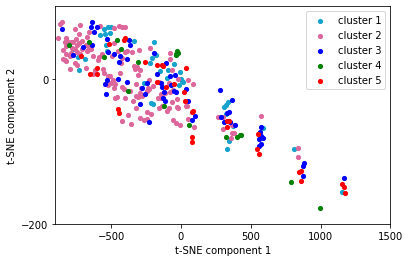

In [ ]:
fig = plt.figure()
clst_to_plot = [10,8,9,1,5]
for color, i in zip(colors, clst_to_plot):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], s = 10, color=color, marker= 'o', lw=lw)
    print(i)

plt.xlabel('t-SNE component 1', fontsize=10)
plt.ylabel('t-SNE component 2', fontsize=10)
plt.locator_params(axis='y', nbins=2)

# ax.yaxis.set_ticks_position('left')

#ax.set_xticks([])
#ax.set_yticks([])

#plt.xlim(-1000, 200)
#plt.ylim(-200, 150)
plt.xlim(-900, 1500)
plt.ylim(-200, 100)
plt.legend(['cluster 1','cluster 2','cluster 3','cluster 4','cluster 5'])
# ax.axis('off')
plt.savefig('./drive/MyDrive/Colab Notebooks/sEEGdata/t_sne_5_neural clusters.pdf',dpi = 300)


 ### pca with all electrode

explained variance ratio (first two components): [0.84639057 0.05412522]


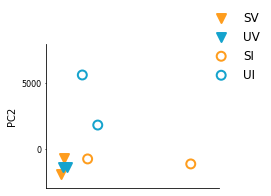

In [ ]:
fig = plt.figure(figsize=(8, 4))

# Calculate mean or variance
X = np.var(Cond_time_elec, axis = 2)
y = np.array(Label_seeg_all)
model = PCA(n_components=2)
X_r = model.fit_transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s' % str(model.explained_variance_ratio_))

target_names = ['Valid', 'Invalid']
colors = [(254/255,157/255,30/255), (21/255,163/255,205/255)]

lw = 2

ax = fig.add_axes([0.2, 0.2, 0.3, 0.5])

# seen
s_row = [0,2,4,6]
X_r_s = X_r[s_row , : ]
for color, i, target_name in zip(colors, [1, 0], target_names):
    plt.scatter(X_r_s[y[s_row] == i, 0], X_r_s[y[s_row] == i, 1], s = 80, color=color, marker= 'v', lw=lw,
                label=target_name)
# unseen
us_row = [1,3,5,7]
X_r_us = X_r[us_row , : ]
for color, i, target_name in zip(colors, [1, 0], target_names):
    plt.scatter(X_r_us[y[us_row] == i, 0], X_r_us[y[us_row] == i, 1], s = 80, color=color, marker= 'o', lw=lw,  facecolors='none',
                label=target_name)

plt.legend(['SV','UV','SI','UI'],loc='best', shadow=False, scatterpoints=1, fontsize = 12, frameon=False, bbox_to_anchor=(0.3, 1.2, 1., .1))


plt.xlim(-10000, 30000)
plt.ylim(-3000, 8000)


plt.xlabel('PC1', fontsize=10)
plt.ylabel('PC2', fontsize=10)
plt.locator_params(axis='y', nbins=2)
ax.tick_params(axis='both', which='major', labelsize=8, length=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_visible(False)
ax.xaxis.set_visible(False)

# ax.axis('off')
# plt.savefig('./drive/MyDrive/Colab Notebooks/figure/pca.png',dpi = 300)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 8 / 8
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.209963
[t-SNE] KL divergence after 1000 iterations: 0.740417


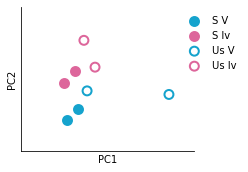

In [ ]:
fig = plt.figure(figsize=(8, 4))

# Calculate mean or variance
X = np.var(Cond_time_elec, axis = 2)
y = np.array(Label_seeg_all)

model = TSNE(n_components=2, random_state=0, init='pca',
                        verbose=1, method='exact',
                        learning_rate=100, perplexity=30)
X_r = model.fit_transform(X)

# Percentage of variance explained for each components

target_names = ['Valid', 'Invalid']
colors = [(21/255,163/255,205/255), (221/255,102/255,155/255)]

lw = 2

ax = fig.add_axes([0.2, 0.2, 0.3, 0.5])

# seen
s_row = [0,2,4,6]
X_r_s = X_r[s_row , : ]
for color, i, target_name in zip(colors, [1, 0], target_names):
    plt.scatter(X_r_s[y[s_row] == i, 0], X_r_s[y[s_row] == i, 1], s = 80, color=color, marker= 'o', lw=lw,
                label=target_name)
# unseen
us_row = [1,3,5,7]
X_r_us = X_r[us_row , : ]
for color, i, target_name in zip(colors, [1, 0], target_names):
    plt.scatter(X_r_us[y[us_row] == i, 0], X_r_us[y[us_row] == i, 1], s = 80, color=color, marker= 'o', lw=lw,  facecolors='none',
                label=target_name)

plt.legend(['S V','S Iv','Us V','Us Iv'],loc='best', shadow=False, scatterpoints=1, fontsize = 10, frameon=False, bbox_to_anchor=(0.3, 0.9, 1., .1))

plt.xlabel('PC1', fontsize=10)
plt.ylabel('PC2', fontsize=10)
plt.locator_params(axis='y', nbins=2)
ax.tick_params(axis='both', which='major', labelsize=8, length=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xticks([])
ax.set_yticks([])

plt.xlim(-20000, 30000)
plt.ylim(-7000, 8000)

# ax.axis('off')
plt.savefig('./drive/MyDrive/Colab Notebooks/sEEGdata/all_t_sne.pdf',dpi = 300)



### Dynamic trajectory

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 90 / 90
[t-SNE] Mean sigma: 0.358013
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.775628
[t-SNE] KL divergence after 500 iterations: 0.101335
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 90 / 90
[t-SNE] Mean sigma: 0.441650
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.255092
[t-SNE] KL divergence after 550 iterations: 0.094364
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 90 / 90
[t-SNE] Mean sigma: 0.404648
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.459226
[t-SNE] KL divergence after 500 iterations: 0.162504
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 90 / 90
[t-SNE] Mean sigma: 0.364873
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.414260
[t-SN

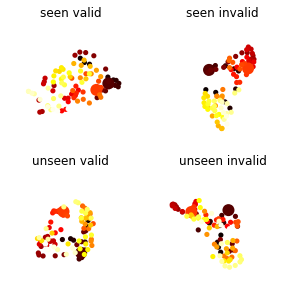

In [ ]:
Label_seeg_all = [0,2,1,3,0,2,1,3]

fig = plt.figure(figsize=(5,5))

target_names = ['seen valid','seen invalid','unseen valid','unseen invalid']
count = 0

markers = []
for i, cond in enumerate(target_names):
  X = np.mean(Cond_time_elec[:,40:130,:], axis = 2)    # var or mean
  y = np.array(Label_seeg_all)
  X_i = X[y == i]

  # calculate PCA
  model = TSNE(n_components=2, random_state=0, init='pca',
                        verbose=1, method='exact',
                        learning_rate=100, perplexity=30)
  X_r = model.fit_transform(X_i.T)


  #ax = fig.add_axes([0.2, 0.2, 0.4, 0.4])
  ax = plt.subplot(2,2,count+1)
  count+=1
  c = np.array(range(X_r.shape[0]))
  s = np.ones(X_r.shape[0]) * 10

  s[10] = 100;
  s[40] = 100;

  cmap = plt.set_cmap('hot')

  plt.scatter(X_r[:,0],X_r[:,1],s = s, c = c,marker = 'o',lw=lw, facecolors= 'none' )

  #plt.xlim([-400,400])
  #plt.ylim([-400,400])

  plt.xlim([-10,10])
  plt.ylim([-10,10])
  plt.title(cond)

  ax.axis('off')

plt.savefig('./drive/MyDrive/Colab Notebooks/sEEGdata/all_dynamic_mean.pdf',dpi = 300)


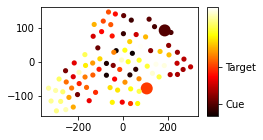

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,2))

cmap = plt.set_cmap('hot')

cax = plt.scatter(X_r[:,0],X_r[:,1],s = s, c = c,marker = 'o',lw=lw, facecolors= 'none' )

cbar = fig.colorbar(cax, ticks = [10, 40],aspect=10)
cbar.ax.set_yticklabels(['Cue', 'Target'])  # vertically oriented colorbar
plt.savefig('./drive/MyDrive/Colab Notebooks/sEEGdata/all_colorbar.png',dpi = 300)


### Dynamic trajectory -cluster

In [ ]:
clust_id_raw = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/sEEGdata/clust_id_k10.mat')
clust_id = clust_id_raw['id'][0]

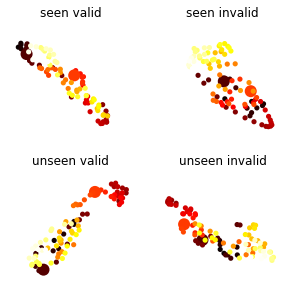

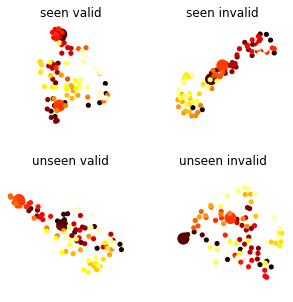

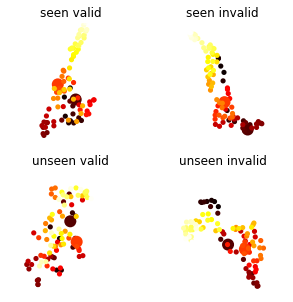

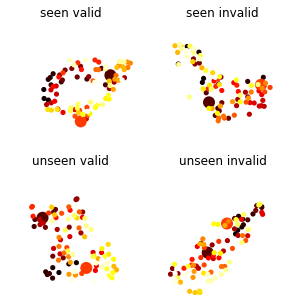

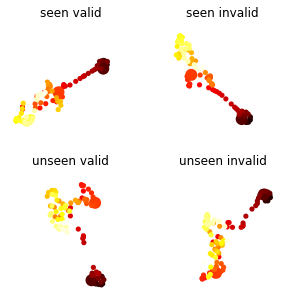

In [ ]:
Label_seeg_all = [0,2,1,3,0,2,1,3]

clust_to_plots = [10,8,9,1,5]

for idx, cst in enumerate(clust_to_plots):

  fig = plt.figure(figsize=(5,5))
  target_names = ['seen valid','seen invalid','unseen valid','unseen invalid']
  count = 0

  markers = []
  for i, cond in enumerate(target_names):
    y = np.array(Label_seeg_all)
    X_i = Cond_time_elec[y == i]
    X_i_avg = np.mean(X_i[:,40:130, clust_id == cst], axis = 2)  # average across elects, then use conditions as features

    # calculate PCA
    model = TSNE(n_components=2, random_state=0, init='pca',
                          verbose=0, method='exact',
                          learning_rate=100, perplexity=30)
    X_r = model.fit_transform(X_i_avg.T)


    #ax = fig.add_axes([0.2, 0.2, 0.4, 0.4])
    ax = plt.subplot(2,2,count+1)
    count+=1
    c = np.array(range(X_r.shape[0]))
    s = np.ones(X_r.shape[0]) * 10

    s[10] = 100;
    s[40] = 100;

    cmap = plt.set_cmap('hot')

    plt.scatter(X_r[:,0],X_r[:,1], s = s, c = c,marker = 'o',lw=lw, facecolors= 'none' )
    #plt.xlim([-600,600])
    #plt.ylim([-600,600])

    plt.title(cond)

    plt.xlim([-8,8])
    plt.ylim([-8,8])

    ax.axis('off')

  plt.savefig('./drive/MyDrive/Colab Notebooks/sEEGdata/clust_dynamic_' +  str(cst) + '.pdf',dpi = 300)
